# Analysis

This notebook contains the code necessary to conduct all data analyses for the Pan 3D Genome project. I have organized this largely by order of appearance in the manuscript; however, a few sections may be out of order. Use the Table of Contents below to navigate to specific analyses.

Note that the genomic windows used to predict the 3D genome are in 0-based coordinates.

## Table of Contents

- [Load Packages and Main Dataframe](#loaddataframe)
- [Data Description](#datadescription)
- [Compare Cell Types](#comparecelltypes)
- [Individually Driven Windows](#individuallydrivenwindows)
    - [IDW In Silico Mutagenesis](#idwindividuallydrivenwindows)
- [Doubleton and Quadrupleton Driven Windows](#doubleandquadruple)
- [Lineage Comparison](#lineagecomparison)
- [Divergent Windows](#divergentwindows)
    - [In Silico Mutagenesis](#divergentwindowsinsilicomutagenesis)
    - [Genes](#divergentwindowsgenes)
    - [Differential Gene Expression](#divergentwindowsexpression)
- [Sequence Divergence](#sequencedivergence)

## Load Packages and Main Dataframe <a class = 'anchor' id = 'loaddataframe'></a>

Load all needed packages, change directories, and load the main dataframe (HFF) that we previously generated.

In [1]:
import json
import numpy as np
import pandas as pd
import pybedtools

from scipy.stats import spearmanr

pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

In [2]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

In [65]:
import matplotlib.font_manager as font_manager
arial_path = '/wynton/home/capra/cbrand/miniconda3/envs/jupyter/fonts/Arial.ttf'
arial = font_manager.FontProperties(fname = arial_path)

In [3]:
cd ../../data

/wynton/group/capra/projects/pan_3d_genome/data


In [4]:
comparisons = pd.read_csv('dataframes/HFF_comparisons.txt', sep = '\t', header = 0)
comparisons.head(5)

,ind1,ind2,dyad_type,chr,window_start,window,mse,spearman,divergence,seq_diff
0,Akwaya-Jean,Alfred,pte-ptt,chr10,1572864,chr10_1572864,0.000168,0.987655,0.012345,2803
1,Akwaya-Jean,Alfred,pte-ptt,chr10,2097152,chr10_2097152,0.000481,0.969809,0.030191,2715
2,Akwaya-Jean,Alfred,pte-ptt,chr10,2621440,chr10_2621440,0.001675,0.996398,0.003602,2849
3,Akwaya-Jean,Alfred,pte-ptt,chr10,3145728,chr10_3145728,0.000323,0.997899,0.002101,2606
4,Akwaya-Jean,Alfred,pte-ptt,chr10,3670016,chr10_3670016,0.000143,0.996732,0.003268,2594


Double check that the frame is the size it should be.

In [5]:
len(comparisons)

6669390

## Data Description <a class = 'anchor' id = 'datadescription'></a>

Let's generate some basic statistics for this dataset before diving into specific analyses.

How many windows are there per chromosome?

In [6]:
comparisons.groupby('chr').size().to_frame('N')

,N
chr,
chr1,525140
chr10,320320
chr11,348040
chr12,323400
chr13,255640
chr14,232540
chr15,184800
chr16,157080
chr17,152460


Let's count the total number of dyads.

In [7]:
comparisons.groupby('dyad_type').size().to_frame('N').sort_values(by = 'N', ascending = False)

,N
dyad_type,
ppn-pt,1836440
pts-ptt,1179439
pts-ptv,661462
ptt-ptv,623041
pts,588889
ptt,520585
pte-pts,366187
pte-ptt,344842
pte-ptv,193615


Let's add all the within chimpanzee comparisons together.

In [8]:
1179439+661462+623041+366187+344842+193615

3368586

How many dyads comparisons are there for a single window?

In [9]:
comparisons[comparisons['window'] == 'chr1_1048576'].groupby('dyad_type').size().to_frame('N').sort_values(by = 'N', ascending = False)

,N
dyad_type,
ppn-pt,423
pts-ptt,272
pts-ptv,153
ptt-ptv,144
pts,136
ptt,120
pte-pts,85
pte-ptt,80
pte-ptv,45


Add the within chimpanzee comparisons again.

In [10]:
272+153+144+85+80+45

779

What is the range of the divergence metric?

In [11]:
comparisons['divergence'].min()

2.492599999737166e-07

In [12]:
comparisons['divergence'].max()

0.873604563894

What does the 0 end of the distribution look like?

In [13]:
len(comparisons[comparisons['divergence'] < 0.01])

5539567

In [14]:
5539567/6669390

0.830595751635457

In [15]:
maxes = comparisons.groupby(['window'])['divergence'].max().to_frame('max').reset_index()
maxes

,window,max
0,chr10_100139008,0.128959
1,chr10_100663296,0.101497
2,chr10_101187584,0.033608
3,chr10_101711872,0.138848
4,chr10_102236160,0.031867
...,...,...
4415,chrX_94371840,0.076931
4416,chrX_94896128,0.044540
4417,chrX_95420416,0.002984
4418,chrX_99090432,0.030925


In [16]:
len(maxes[maxes['max'] < 0.005])

245

In [17]:
len(maxes[maxes['max'] < 0.01])

874

In [18]:
comparisons.sort_values(by = 'divergence', ascending = True).head(10).reset_index()

,index,ind1,ind2,dyad_type,chr,window_start,window,mse,spearman,divergence,seq_diff
0,1281542,Berta,Linda,ptv,chrX,63963136,chrX_63963136,1.002406e-07,1.000000,2.492600e-07,28
1,2011332,Bosco,Clint,ptv,chr18,30408704,chr18_30408704,1.512933e-07,1.000000,3.000030e-07,12
2,6211267,Maya,Washu,pts,chr4,77594624,chr4_77594624,1.090777e-07,1.000000,4.526210e-07,11
3,6211263,Maya,Washu,pts,chr4,74448896,chr4_74448896,2.951117e-07,0.999999,9.595860e-07,16
4,6211268,Maya,Washu,pts,chr4,78118912,chr4_78118912,2.513768e-07,0.999999,1.000161e-06,16
5,1234648,Berta,Jimmie,ptv,chr18,30408704,chr18_30408704,5.041597e-07,0.999999,1.196607e-06,27
6,6211265,Maya,Washu,pts,chr4,75497472,chr4_75497472,4.510030e-07,0.999998,1.994036e-06,21
7,6211270,Maya,Washu,pts,chr4,79167488,chr4_79167488,6.245179e-07,0.999998,2.295157e-06,22
8,6211269,Maya,Washu,pts,chr4,78643200,chr4_78643200,5.665585e-07,0.999997,2.748579e-06,14
9,1156145,Berta,Bosco,ptv,chr18,30408704,chr18_30408704,2.477392e-06,0.999997,2.755416e-06,42


Let's take a peek at some of the very divergent windows. How many are very (>= 0.3) divergent?

In [19]:
len(comparisons[comparisons['divergence'] >= 0.25])

8745

In [20]:
len(comparisons[comparisons['divergence'] >= 0.3])

5251

In [21]:
len(comparisons[comparisons['divergence'] >= 0.3]['window'].unique())

87

In [22]:
thing = comparisons[comparisons['divergence'] >= 0.3].groupby(['window']).size().to_frame()
thing

,0
window,
chr10_106954752,7
chr10_19922944,16
chr10_48758784,6
chr10_52428800,108
chr10_52953088,53
chr11_20447232,28
chr11_20971520,41
chr12_126353408,2
chr12_80216064,1


Explore the dataframe.

In [23]:
comparisons.sort_values(by = 'divergence', ascending = False).head(10).reset_index()

,index,ind1,ind2,dyad_type,chr,window_start,window,mse,spearman,divergence,seq_diff
0,1239468,Berta,Julie-A959,ptt-ptv,chr1,169345024,chr1_169345024,0.029880,0.126395,0.873605,2419
1,1187032,Berta,Clint,ptv,chr1,169345024,chr1_169345024,0.027221,0.138562,0.861438,556
2,1178192,Berta,Cindy-verus,ptv,chr1,169345024,chr1_169345024,0.027594,0.138759,0.861241,1056
3,475742,Alice,Berta,ptv,chr1,169345024,chr1_169345024,0.027315,0.140083,0.859917,844
4,1235048,Berta,Jimmie,ptv,chr1,169345024,chr1_169345024,0.027005,0.143166,0.856834,850
5,1252728,Berta,Koby,ptv,chr1,169345024,chr1_169345024,0.027171,0.144921,0.855079,855
6,1318575,Berta,SeppToni,ptv,chr1,169345024,chr1_169345024,0.026837,0.145195,0.854805,996
7,1278946,Berta,Linda,ptv,chr1,169345024,chr1_169345024,0.026589,0.148939,0.851061,933
8,1156545,Berta,Bosco,ptv,chr1,169345024,chr1_169345024,0.026644,0.150587,0.849413,864
9,1327264,Berta,Tibe,ptt-ptv,chr1,169345024,chr1_169345024,0.026827,0.162322,0.837678,2953


Get divergence scores for Figure 1C examples.

In [24]:
comparisons[(comparisons['window'] == 'chr4_77594624') & (comparisons['ind1'] == 'Maya') & (comparisons['ind2'] == 'Washu')]

,ind1,ind2,dyad_type,chr,window_start,window,mse,spearman,divergence,seq_diff
6211267,Maya,Washu,pts,chr4,77594624,chr4_77594624,1.090777e-07,1.0,4.526210e-07,11


In [25]:
comparisons[(comparisons['window'] == 'chr18_46137344') & (comparisons['ind1'] == 'Julie-A959') & (comparisons['ind2'] == 'Vincent')]

,ind1,ind2,dyad_type,chr,window_start,window,mse,spearman,divergence,seq_diff
5136420,Julie-A959,Vincent,pts-ptt,chr18,46137344,chr18_46137344,0.020585,0.350611,0.649389,3049


## Compare Cell Types <a class = 'anchor' id = 'comparecelltypes'></a>

Are the cell type specific predictions variable across cell types for the reference sequence?

In [45]:
reference_comparisons_header = ['cell_type_1','cell_type_2','chr','window_start','mse','spearman']
reference_comparisons = pd.read_csv('comparisons/reference/all_reference_comparisons.txt', sep = '\t', names = reference_comparisons_header)
reference_comparisons['window'] = reference_comparisons['chr'] + '_' + reference_comparisons['window_start'].astype(str)
reference_comparisons = reference_comparisons[['cell_type_1','cell_type_2','chr','window_start','window','mse','spearman']]
reference_comparisons.head()

,cell_type_1,cell_type_2,chr,window_start,window,mse,spearman
0,GM12878,H1ESC,chr10,0,chr10_0,0.007478,0.975894
1,GM12878,H1ESC,chr10,524288,chr10_524288,0.011195,0.979405
2,GM12878,H1ESC,chr10,1048576,chr10_1048576,0.008226,0.964848
3,GM12878,H1ESC,chr10,1572864,chr10_1572864,0.004235,0.843366
4,GM12878,H1ESC,chr10,2097152,chr10_2097152,0.004803,0.904270


In [46]:
excluded_header = ['chr','start','end','N_missing']
excluded = pd.read_csv('metadata/panTro6_excluded_windows.bed', sep = '\t', header = None, names = excluded_header)
excluded['window'] = excluded['chr'] + '_' + excluded['start'].astype(str)
excluded_windows = excluded['window'].tolist()

In [47]:
reference_comparisons = reference_comparisons[~(reference_comparisons['window'].isin(excluded_windows))]
reference_comparisons.head()

,cell_type_1,cell_type_2,chr,window_start,window,mse,spearman
3,GM12878,H1ESC,chr10,1572864,chr10_1572864,0.004235,0.843366
4,GM12878,H1ESC,chr10,2097152,chr10_2097152,0.004803,0.904270
5,GM12878,H1ESC,chr10,2621440,chr10_2621440,0.011546,0.984242
6,GM12878,H1ESC,chr10,3145728,chr10_3145728,0.010323,0.968420
7,GM12878,H1ESC,chr10,3670016,chr10_3670016,0.005837,0.926094


Let's save this dataframe for plotting.

In [59]:
reference_comparisons.to_csv('dataframes/reference_cell_type_comparisons.txt', sep = '\t', header = True, index = False)

In [48]:
len(reference_comparisons)

44200

In [54]:
reference_comparisons.groupby(['cell_type_1','cell_type_2'])['spearman'].mean().to_frame('Mean Rho')

Mean Rho
cell_type_1 cell_type_2          
GM12878     H1ESC        0.964364
            HCT116       0.982633
            HFF          0.977558
            IMR90        0.994160
H1ESC       HCT116       0.951985
            HFF          0.979460
            IMR90        0.962741
HCT116      HFF          0.973256
            IMR90        0.984992
HFF         IMR90        0.984033

Most of the maps for the different cell types are nearly identical when predicting the reference sequence.

Let's compare sample predictions from HFF to GM12878. Load the data and run a correlation.

In [26]:
GM12878_comparisons = pd.read_csv('dataframes/GM12878_comparisons.txt', sep = '\t', header = 0)
GM12878_comparisons.head(5)

,ind1,ind2,chr,window_start,window,mse,spearman,divergence
0,Akwaya-Jean,Alfred,chr10,1572864,chr10_1572864,0.000057,0.985524,0.014476
1,Akwaya-Jean,Alfred,chr10,2097152,chr10_2097152,0.000183,0.966059,0.033941
2,Akwaya-Jean,Alfred,chr10,2621440,chr10_2621440,0.000751,0.997055,0.002945
3,Akwaya-Jean,Alfred,chr10,3145728,chr10_3145728,0.000114,0.998515,0.001485
4,Akwaya-Jean,Alfred,chr10,3670016,chr10_3670016,0.000056,0.997281,0.002719


In [27]:
rho, p = spearmanr(comparisons['divergence'], GM12878_comparisons['divergence'])
print(rho, p)

0.9893313007567661 0.0


In [28]:
HFF_divergence = comparisons[['ind1','ind2','window','divergence']].copy()
HFF_divergence['cell_type'] = 'HFF'
GM12878_divergence = GM12878_comparisons[['ind1','ind2','window','divergence']].copy()
GM12878_divergence['cell_type'] = 'GM12878'
cell_type_correlation = HFF_divergence.merge(GM12878_divergence, how = 'outer', on = ['ind1','ind2','window'])
cell_type_correlation = cell_type_correlation[['ind1','ind2','window','cell_type_x','divergence_x','cell_type_y','divergence_y']]
cell_type_correlation.head()

,ind1,ind2,window,cell_type_x,divergence_x,cell_type_y,divergence_y
0,Akwaya-Jean,Alfred,chr10_1572864,HFF,0.012345,GM12878,0.014476
1,Akwaya-Jean,Alfred,chr10_2097152,HFF,0.030191,GM12878,0.033941
2,Akwaya-Jean,Alfred,chr10_2621440,HFF,0.003602,GM12878,0.002945
3,Akwaya-Jean,Alfred,chr10_3145728,HFF,0.002101,GM12878,0.001485
4,Akwaya-Jean,Alfred,chr10_3670016,HFF,0.003268,GM12878,0.002719


In [29]:
len(cell_type_correlation)

6669390

Save this dataframe for plotting.

In [30]:
cell_type_correlation.to_csv('dataframes/cell_type_correlation.txt', sep = '\t', header = True, index = False)

After plotting, there is a noticeable cluster of windows with low HFF divergence but high GM12878 divergence. Let's take a look.

In [31]:
high_GM12878_windows = cell_type_correlation[(cell_type_correlation['divergence_x'] < 0.075) & (cell_type_correlation['divergence_y'] > 0.1)]
high_GM12878_windows.head()

,ind1,ind2,window,cell_type_x,divergence_x,cell_type_y,divergence_y
13056,Akwaya-Jean,Athanga,chr11_23068672,HFF,0.009928,GM12878,0.201436
32801,Akwaya-Jean,Bono,chr4_94371840,HFF,0.037738,GM12878,0.289263
49764,Akwaya-Jean,Cindy-schwein,chr4_30932992,HFF,0.066314,GM12878,0.103239
79760,Akwaya-Jean,Desmond,chr4_94371840,HFF,0.019318,GM12878,0.249087
88298,Akwaya-Jean,Dzeeta,chr4_94371840,HFF,0.025871,GM12878,0.277738


In [32]:
len(high_GM12878_windows)

1103

In [33]:
high_GM12878_windows.groupby('window')['divergence_y'].count().to_frame()

,divergence_y
window,
chr10_1572864,80
chr10_2097152,18
chr10_60293120,16
chr11_23068672,206
chr11_48758784,20
chr13_51904512,6
chr13_62390272,1
chr14_26214400,8
chr14_26738688,3


Two windows stick out in particular. Are these maps very different in the reference sequence?

In [56]:
reference_comparisons[(reference_comparisons['cell_type_1'] == 'GM12878') & (reference_comparisons['cell_type_2'] == 'HFF') & (reference_comparisons['window'] == 'chr4_94371840')]

,cell_type_1,cell_type_2,chr,window_start,window,mse,spearman
14085,GM12878,HFF,chr4,94371840,chr4_94371840,0.00362,0.959098


In [57]:
reference_comparisons[(reference_comparisons['cell_type_1'] == 'GM12878') & (reference_comparisons['cell_type_2'] == 'HFF') & (reference_comparisons['window'] == 'chr11_23068672')]

,cell_type_1,cell_type_2,chr,window_start,window,mse,spearman
10924,GM12878,HFF,chr11,23068672,chr11_23068672,0.003429,0.95801


## Dendrograms

Write a function that plots the dendrogram from a given window.

In [131]:
def get_window_dendrogram(window):
    window_df = comparisons[comparisons['window'] == window]
    idx = sorted(set(window_df['ind1']).union(window_df['ind2']))
    array = window_df.pivot(index='ind1', columns='ind2', values='divergence').reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
    
    fig, ax = plt.subplots(1, figsize=(8,8))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    condensed = array[np.triu_indices(56, k = 1)]
    dendrogram = sch.dendrogram(sch.linkage(condensed, method = 'complete'))
    
    plt.xlabel('Samples', fontproperties = arial) # label of the x-axis
    plt.ylabel('Divergence', fontproperties = arial) # label of the y-axis
    plt.yticks(fontproperties = arial)
    
    #plt.savefig('../plots/dendrograms/%s_tree.pdf' % (window), bbox_inches = 'tight', transparent = True)
    #plt.show()
    
    #return dendrogram

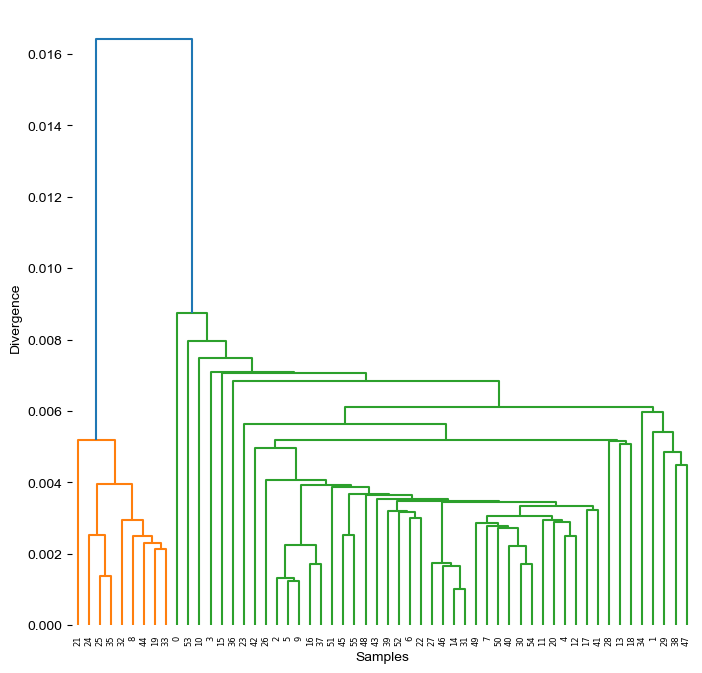

In [83]:
get_window_dendrogram('chr10_1572864')

Run a script to generate trees per window, grab the cluster identity per individual, and catch the y-coordinates of the top four nodes in the tree. 

In [84]:
average_linkage_trees = pd.read_csv('dataframes/average_linkage_clustering_per_window.txt', sep = '\t', header = None)
complete_linkage_trees = pd.read_csv('dataframes/complete_linkage_clustering_per_window.txt', sep = '\t', header = None)
single_linkage_trees = pd.read_csv('dataframes/single_linkage_clustering_per_window.txt', sep = '\t', header = None)

In [85]:
single_linkage_trees.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,chr10_1572864,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.005200,0.016430,0.016430,0.008743
1,chr10_2097152,C3,C2,C3,C3,C0,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C2,C3,C3,C3,C3,C3,C3,C2,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C1,C1,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,0.000000,0.030077,0.030077,0.028291
2,chr10_2621440,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.001941,0.004083,0.004083,0.002646
3,chr10_3145728,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.000000,0.002893,0.002893,0.001534
4,chr10_3670016,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C0,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.002369,0.008749,0.008749,0.007682


In [86]:
autosomal_average_linkage_trees = average_linkage_trees[~average_linkage_trees[0].str.startswith('chrX_')]
chrX_average_linkage_trees = average_linkage_trees[average_linkage_trees[0].str.startswith('chrX_')]

autosomal_complete_linkage_trees = complete_linkage_trees[~complete_linkage_trees[0].str.startswith('chrX_')]
chrX_complete_linkage_trees = complete_linkage_trees[complete_linkage_trees[0].str.startswith('chrX_')]

autosomal_single_linkage_trees = single_linkage_trees[~single_linkage_trees[0].str.startswith('chrX_')]
chrX_single_linkage_trees = single_linkage_trees[single_linkage_trees[0].str.startswith('chrX_')]

In [87]:
autosomal_trees_header = ['window','Akwaya-Jean','Alfred','Alice','Andromeda','Athanga','Berta','Bihati','Blanquita','Bono','Bosco','Brigitta','Bwamble','Cindy-schwein','Cindy-troglodytes','Cindy-verus','Cleo','Clint','Coco-chimp','Damian','Desmond','Doris','Dzeeta','Frederike','Gamin','Hermien','Hortense','Ikuru','Jimmie','Julie-A959','Julie-LWC21','Kidongo','Koby','Kombote','Kosana','Koto','Kumbuka','Lara','Linda','Luky','Marlin','Maya','Mgbadolite','Mirinda','Nakuu','Natalie','Negrita','SeppToni','Taweh','Tibe','Tongo','Trixie','Ula','Vaillant','Vincent','Washu','Yogui','node_0','node_1','node_2','node_3']

autosomal_average_linkage_trees.columns = autosomal_trees_header
autosomal_complete_linkage_trees.columns = autosomal_trees_header
autosomal_single_linkage_trees.columns = autosomal_trees_header

In [88]:
def cluster_counts(dataframe):
    updated_dataframe = dataframe.copy()
    updated_dataframe['MRCA_ratio'] = (updated_dataframe['node_2'] - updated_dataframe['node_3'])/(updated_dataframe['node_1'] - updated_dataframe['node_0']) 
    updated_dataframe['C0_count'] = updated_dataframe.apply(lambda row: row[row == 'C0'].count(), axis = 1)
    updated_dataframe['C1_count'] = updated_dataframe.apply(lambda row: row[row == 'C1'].count(), axis = 1)
    updated_dataframe['C2_count'] = updated_dataframe.apply(lambda row: row[row == 'C2'].count(), axis = 1)
    updated_dataframe['C3_count'] = updated_dataframe.apply(lambda row: row[row == 'C3'].count(), axis = 1)
    updated_dataframe['C4_count'] = updated_dataframe.apply(lambda row: row[row == 'C4'].count(), axis = 1)
    updated_dataframe['C5_count'] = updated_dataframe.apply(lambda row: row[row == 'C5'].count(), axis = 1)
    updated_dataframe['C6_count'] = updated_dataframe.apply(lambda row: row[row == 'C6'].count(), axis = 1)
    return updated_dataframe

In [89]:
updated_autosomal_average_linkage_trees = cluster_counts(autosomal_average_linkage_trees)

In [90]:
updated_autosomal_complete_linkage_trees = cluster_counts(autosomal_complete_linkage_trees)

In [91]:
updated_autosomal_single_linkage_trees = cluster_counts(autosomal_single_linkage_trees)

In [92]:
len(updated_autosomal_average_linkage_trees[(updated_autosomal_average_linkage_trees['C0_count'] == 1) & (updated_autosomal_average_linkage_trees['C1_count'] == 55)])

1098

In [93]:
len(updated_autosomal_complete_linkage_trees[(updated_autosomal_complete_linkage_trees['C0_count'] == 1) & (updated_autosomal_complete_linkage_trees['C1_count'] == 55)])

771

In [94]:
len(updated_autosomal_single_linkage_trees[(updated_autosomal_single_linkage_trees['C0_count'] == 1) & (updated_autosomal_single_linkage_trees['C1_count'] == 55)])

1301

In [95]:
updated_autosomal_single_linkage_trees[(updated_autosomal_single_linkage_trees['C0_count'] == 1) & (updated_autosomal_single_linkage_trees['C1_count'] == 55)].head(15)

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3,MRCA_ratio,C0_count,C1_count,C2_count,C3_count,C4_count,C5_count,C6_count
3,chr10_3145728,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.002893,0.002893,0.001534,0.469755,1,55,0,0,0,0,0
11,chr10_8388608,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.059351,0.059351,0.024549,0.586375,1,55,0,0,0,0,0
15,chr10_10485760,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.031188,0.031188,0.003103,0.900508,1,55,0,0,0,0,0
16,chr10_11010048,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.011222,0.011222,0.002889,0.742577,1,55,0,0,0,0,0
17,chr10_11534336,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.001389,0.001389,0.000757,0.455222,1,55,0,0,0,0,0
24,chr10_17301504,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.024824,0.024824,0.013999,0.436082,1,55,0,0,0,0,0
29,chr10_20971520,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.014485,0.014485,0.002596,0.820741,1,55,0,0,0,0,0
30,chr10_21495808,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.008999,0.008999,0.000981,0.890967,1,55,0,0,0,0,0
32,chr10_22544384,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.001041,0.001041,0.000576,0.446478,1,55,0,0,0,0,0
35,chr10_24117248,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.013004,0.013004,0.002875,0.778886,1,55,0,0,0,0,0


In [96]:
len(updated_autosomal_complete_linkage_trees[(updated_autosomal_complete_linkage_trees['C1_count'] == 9) & (updated_autosomal_complete_linkage_trees['C2_count'] == 47)])

346

In [97]:
len(updated_autosomal_complete_linkage_trees[(updated_autosomal_complete_linkage_trees['C1_count'] == 47) & (updated_autosomal_complete_linkage_trees['C2_count'] == 9)])

40

In [98]:
def lineage_checker(dataframe, ppn_value,pte_value,pts_value,ptt_value,ptv_value):
    filtered_dataframe = dataframe[
        (dataframe['Akwaya-Jean'] == pte_value) &
        (dataframe['Alfred'] == ptt_value) &
        (dataframe['Alice'] == ptv_value) &
        (dataframe['Andromeda'] == pts_value) &
        (dataframe['Athanga'] == pts_value) &
        (dataframe['Berta'] == ptv_value) &
        (dataframe['Bihati'] == pts_value) &
        (dataframe['Blanquita'] == ptt_value) &
        (dataframe['Bono'] == ppn_value) &
        (dataframe['Bosco'] == ptv_value) &
        (dataframe['Brigitta'] == ptt_value) &
        (dataframe['Bwamble'] == pts_value) &
        (dataframe['Cindy-schwein'] == pts_value) &
        (dataframe['Cindy-troglodytes'] == ptt_value) &
        (dataframe['Cindy-troglodytes'] == ptt_value) &
        (dataframe['Cindy-verus'] == ptv_value) &
        (dataframe['Cleo'] == pts_value) &
        (dataframe['Clint'] == ptv_value) &
        (dataframe['Coco-chimp'] == pts_value) &
        (dataframe['Damian'] == pte_value) &
        (dataframe['Desmond'] == ppn_value) &
        (dataframe['Doris'] == ptt_value) &
        (dataframe['Dzeeta'] == ppn_value) &
        (dataframe['Frederike'] == pts_value) &
        (dataframe['Gamin'] == ptt_value) &
        (dataframe['Hermien'] == ppn_value) &
        (dataframe['Hortense'] == ppn_value) &
        (dataframe['Ikuru'] == pts_value) &
        (dataframe['Jimmie'] == ptv_value) &
        (dataframe['Julie-A959'] == ptt_value) &
        (dataframe['Julie-LWC21'] == pte_value) &
        (dataframe['Kidongo'] == pts_value) &
        (dataframe['Koby'] == ptv_value) &
        (dataframe['Kombote'] == ppn_value) &
        (dataframe['Kosana'] == ppn_value) &
        (dataframe['Koto'] == pte_value) &
        (dataframe['Kumbuka'] == ppn_value) &
        (dataframe['Lara'] == ptt_value) &
        (dataframe['Linda'] == ptv_value) &
        (dataframe['Luky'] == ptt_value) &
        (dataframe['Marlin'] == ptt_value) &
        (dataframe['Maya'] == pts_value) &
        (dataframe['Mgbadolite'] == pts_value) &
        (dataframe['Mirinda'] == ptt_value) &
        (dataframe['Nakuu'] == pts_value) &
        (dataframe['Natalie'] == ppn_value) &
        (dataframe['Negrita'] == ptt_value) &
        (dataframe['SeppToni'] == ptv_value) &
        (dataframe['Taweh'] == pte_value) &
        (dataframe['Tibe'] == ptt_value) &
        (dataframe['Tongo'] == pts_value) &
        (dataframe['Trixie'] == pts_value) &
        (dataframe['Ula'] == ptt_value) &
        (dataframe['Vaillant'] == ptt_value) &
        (dataframe['Vincent'] == pts_value) &
        (dataframe['Washu'] == pts_value) &
        (dataframe['Yogui'] == ptt_value)]
    
    return filtered_dataframe

In [99]:
thing1 = lineage_checker(updated_autosomal_average_linkage_trees,'C1','C2','C2','C2','C2')
len(thing1)

222

In [100]:
thing6 = lineage_checker(updated_autosomal_average_linkage_trees,'C2','C1','C1','C1','C1')
len(thing6)

36

In [101]:
thing2 = lineage_checker(updated_autosomal_complete_linkage_trees,'C1','C2','C2','C2','C2')
len(thing2)

289

In [102]:
thing5 = lineage_checker(updated_autosomal_complete_linkage_trees,'C2','C1','C1','C1','C1')
len(thing5)

26

In [103]:
thing3 = lineage_checker(updated_autosomal_single_linkage_trees,'C1','C2','C2','C2','C2')
len(thing3)

164

In [104]:
thing4 = lineage_checker(updated_autosomal_single_linkage_trees,'C2','C1','C1','C1','C1')
len(thing4)

31

In [105]:
thing3

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3,MRCA_ratio,C0_count,C1_count,C2_count,C3_count,C4_count,C5_count,C6_count
0,chr10_1572864,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.005200,0.016430,0.016430,0.008743,0.684539,0,9,47,0,0,0,0
48,chr10_30932992,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.001483,0.003739,0.003739,0.001579,0.957425,0,9,47,0,0,0,0
57,chr10_35651584,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.001578,0.008075,0.008075,0.005171,0.447015,0,9,47,0,0,0,0
115,chr10_72876032,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000558,0.002122,0.002122,0.001183,0.600681,0,9,47,0,0,0,0
122,chr10_78118912,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000804,0.003736,0.003736,0.002204,0.522676,0,9,47,0,0,0,0
123,chr10_78643200,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.003208,0.011702,0.011702,0.007765,0.463466,0,9,47,0,0,0,0
125,chr10_79691776,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.002532,0.004175,0.004175,0.002890,0.782603,0,9,47,0,0,0,0
136,chr10_87031808,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000516,0.008621,0.008621,0.000946,0.946874,0,9,47,0,0,0,0
137,chr10_87556096,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000174,0.026767,0.026767,0.002077,0.928420,0,9,47,0,0,0,0
156,chr10_97517568,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000153,0.000400,0.000400,0.000212,0.763077,0,9,47,0,0,0,0


In [111]:
len(thing4[thing4['window'].isin(divergent_windows_list)])

13

In [112]:
len(thing3[thing3['window'].isin(divergent_windows_list)])

46

In [113]:
len(thing3[thing3['MRCA_ratio'] > 0.8])

67

In [114]:
thing3[thing3['window'].isin(divergent_windows_list)]

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3,MRCA_ratio,C0_count,C1_count,C2_count,C3_count,C4_count,C5_count,C6_count
136,chr10_87031808,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000516,0.008621,0.008621,0.000946,0.946874,0,9,47,0,0,0,0
137,chr10_87556096,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000174,0.026767,0.026767,0.002077,0.928420,0,9,47,0,0,0,0
500,chr12_44040192,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.001820,0.054170,0.054170,0.005632,0.927192,0,9,47,0,0,0,0
719,chr13_45088768,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000936,0.041128,0.041128,0.002645,0.957494,0,9,47,0,0,0,0
720,chr13_45613056,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.004051,0.304855,0.304855,0.004138,0.999710,0,9,47,0,0,0,0
723,chr13_47185920,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.001867,0.048146,0.048146,0.003890,0.956298,0,9,47,0,0,0,0
750,chr13_61341696,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000201,0.008538,0.008538,0.001660,0.825006,0,9,47,0,0,0,0
863,chr14_32505856,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000657,0.011372,0.011372,0.001529,0.918638,0,9,47,0,0,0,0
887,chr14_45088768,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000781,0.020095,0.020095,0.000792,0.999418,0,9,47,0,0,0,0
888,chr14_45613056,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.000950,0.019686,0.019686,0.002084,0.939492,0,9,47,0,0,0,0


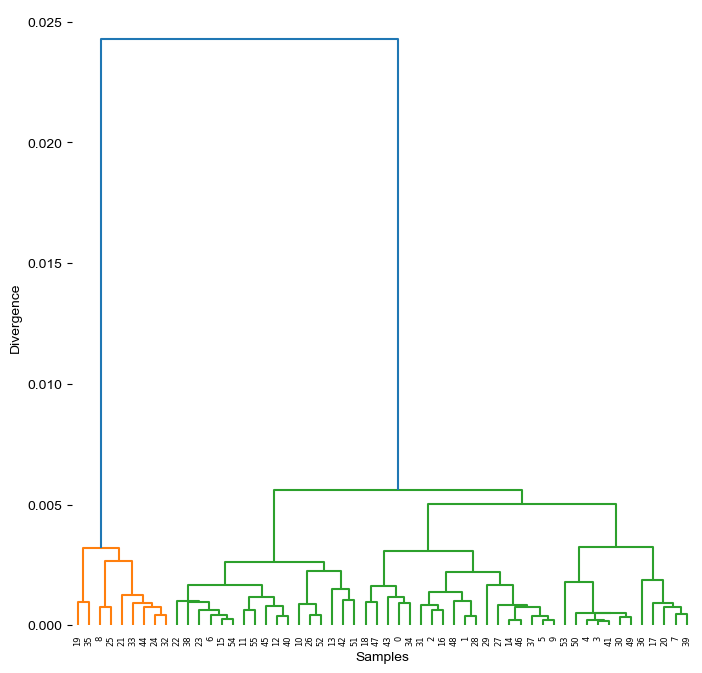

In [132]:
get_window_dendrogram('chr10_30932992')

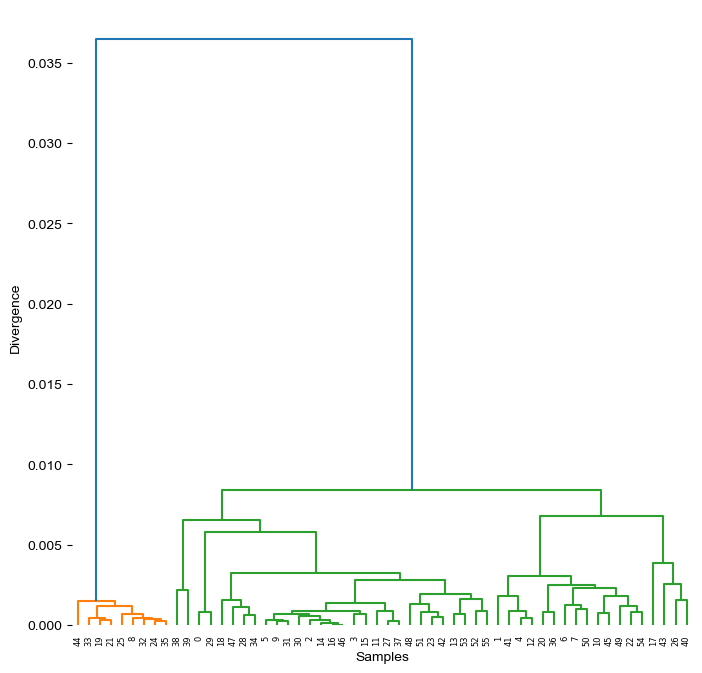

In [133]:
get_window_dendrogram('chr14_32505856')

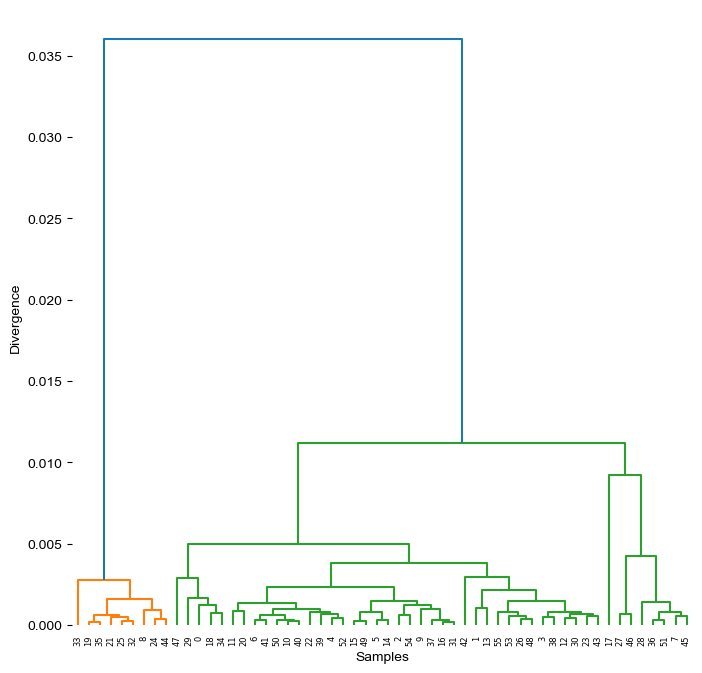

In [134]:
get_window_dendrogram('chr9_104857600')

In [135]:
comparisons[comparisons['window'] == 'chr9_104857600'].sort_values(by = 'divergence', ascending = False).reset_index()[1:424]

,index,ind1,ind2,dyad_type,chr,window_start,window,mse,spearman,divergence,seq_diff
1,4982014,Jimmie,Natalie,ppn-pt,chr9,104857600,chr9_104857600,0.014811,0.964028,0.035972,3139
2,4933696,Jimmie,Kosana,ppn-pt,chr9,104857600,chr9_104857600,0.014852,0.964172,0.035828,3009
3,1864846,Bono,Jimmie,ppn-pt,chr9,104857600,chr9_104857600,0.014312,0.964970,0.035030,3206
4,4526864,Hermien,Jimmie,ppn-pt,chr9,104857600,chr9_104857600,0.014016,0.965907,0.034093,3081
5,4110245,Dzeeta,Jimmie,ppn-pt,chr9,104857600,chr9_104857600,0.013487,0.966786,0.033214,3078
6,4929276,Jimmie,Kombote,ppn-pt,chr9,104857600,chr9_104857600,0.013548,0.967119,0.032881,3077
7,6394052,Natalie,SeppToni,ppn-pt,chr9,104857600,chr9_104857600,0.013421,0.967133,0.032867,3201
8,5630477,Kosana,SeppToni,ppn-pt,chr9,104857600,chr9_104857600,0.013458,0.967218,0.032782,3087
9,4741632,Hortense,SeppToni,ppn-pt,chr9,104857600,chr9_104857600,0.013190,0.967238,0.032762,3163
10,3811305,Desmond,Jimmie,ppn-pt,chr9,104857600,chr9_104857600,0.013157,0.968065,0.031935,3078


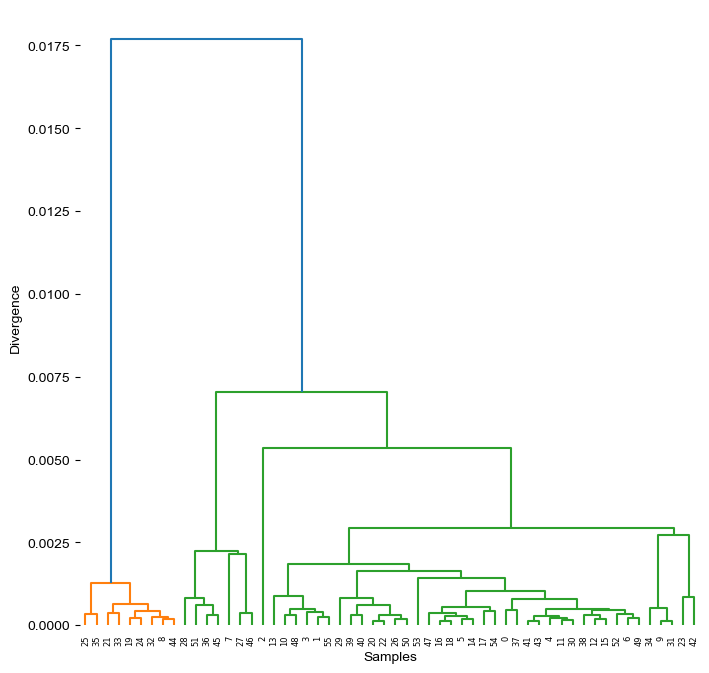

In [136]:
get_window_dendrogram('chr9_105381888')

In [137]:
comparisons[comparisons['window'] == 'chr9_105381888'].sort_values(by = 'divergence', ascending = False).reset_index()[1:420]

,index,ind1,ind2,dyad_type,chr,window_start,window,mse,spearman,divergence,seq_diff
1,1696242,Blanquita,Kumbuka,ppn-pt,chr9,105381888,chr9_105381888,0.007852,0.982471,0.017529,3570
2,5763421,Kumbuka,Lara,ppn-pt,chr9,105381888,chr9_105381888,0.007700,0.983078,0.016922,3529
3,4658106,Hortense,Jimmie,ppn-pt,chr9,105381888,chr9_105381888,0.007478,0.983132,0.016868,2675
4,4697584,Hortense,Lara,ppn-pt,chr9,105381888,chr9_105381888,0.007558,0.983321,0.016679,3282
5,4741633,Hortense,SeppToni,ppn-pt,chr9,105381888,chr9_105381888,0.007321,0.983519,0.016481,2807
6,4942386,Jimmie,Kumbuka,ppn-pt,chr9,105381888,chr9_105381888,0.007323,0.983563,0.016437,3074
7,5807470,Kumbuka,SeppToni,ppn-pt,chr9,105381888,chr9_105381888,0.007179,0.983918,0.016082,3178
8,1634815,Blanquita,Dzeeta,ppn-pt,chr9,105381888,chr9_105381888,0.007142,0.984080,0.015920,3320
9,1647924,Blanquita,Hermien,ppn-pt,chr9,105381888,chr9_105381888,0.007084,0.984313,0.015687,3350
10,4110246,Dzeeta,Jimmie,ppn-pt,chr9,105381888,chr9_105381888,0.007011,0.984399,0.015601,2700


## Individually Driven Windows <a class = 'anchor' id = 'individuallydrivenwindows'></a>

Some of these highly divergent windows appear to be driven by individuals that are different to all others, regardless of population. Let's try to write a function to identify windows where a single individual is very divergent. Start with a list of unique windows.

In [34]:
windows_list = comparisons['window'].unique().tolist()

Windows where a single individual is unique should be characterized by 55 comparisons that include that individual as ind1 or ind2 with a divergence score higher than all other comparisons. Therefore, we can sort each window by decreasing divergence and count the number of times each individual appears in the top 55 comparisons. If this count = 55, we have an individually driven window ('max'). We should also consider the mean value for those 55 comparisons because IDWs should have a relatively large value ('55_mean'). Further, there should be a considerable difference in the divergence score between the 55th and 56th comparisons ('55_56_diff'). Finally, the variance of the divergence score for the entire window should be large for IDWs ('window_variance').

In [35]:
def individual_driven_windows():
    
    counts_list = []
    means_list = []
    diffs_list = []
    variance_list = []
    
    for window in windows_list:
        subset = comparisons[comparisons['window'] == window].sort_values(by = 'divergence', ascending = False).reset_index()
        top_subset = subset[0:55]
        id1 = top_subset.groupby(['ind1']).size().reset_index(name='N').rename(columns={'ind1': 'ind'})
        id2 = top_subset.groupby(['ind2']).size().reset_index(name='N').rename(columns={'ind2': 'ind'})
        id_total = pd.concat([id1, id2]).groupby(['ind']).sum().reset_index()
        window_dict = dict(zip(id_total.ind, id_total.N))
        counts_list.append(window_dict)
        
        subset_mean = subset['divergence'].iloc[0:55].mean()
        means_list.append(subset_mean)
        
        subset_diff = subset['divergence'].iloc[54] - subset['divergence'].iloc[55]
        diffs_list.append(subset_diff)
        
        variance = subset['divergence'].var()
        variance_list.append(variance)
        
    df = pd.DataFrame.from_dict(counts_list)
    df['window'] = windows_list
    df['max'] = df[['Akwaya-Jean','Alfred','Alice','Andromeda','Athanga','Berta','Bihati','Blanquita','Bono','Bosco','Brigitta','Bwamble','Cindy-schwein','Cindy-troglodytes','Cindy-verus','Cleo','Clint','Coco-chimp','Damian','Desmond','Doris','Dzeeta','Frederike','Gamin','Hermien','Hortense','Ikuru','Jimmie','Julie-A959','Julie-LWC21','Kidongo','Koby','Kombote','Kosana','Koto','Kumbuka','Lara','Linda','Luky','Marlin','Maya','Mgbadolite','Mirinda','Nakuu','Natalie','Negrita','SeppToni','Taweh','Tibe','Tongo','Trixie','Ula','Vaillant','Vincent','Washu','Yogui']].max(axis=1)
    df['55_mean'] = means_list
    df['55_56_diff'] = diffs_list
    df['window_variance'] = variance_list
    df = df[['window','Akwaya-Jean','Alfred','Alice','Andromeda','Athanga','Berta','Bihati','Blanquita','Bono','Bosco','Brigitta','Bwamble','Cindy-schwein','Cindy-troglodytes','Cindy-verus','Cleo','Clint','Coco-chimp','Damian','Desmond','Doris','Dzeeta','Frederike','Gamin','Hermien','Hortense','Ikuru','Jimmie','Julie-A959','Julie-LWC21','Kidongo','Koby','Kombote','Kosana','Koto','Kumbuka','Lara','Linda','Luky','Marlin','Maya','Mgbadolite','Mirinda','Nakuu','Natalie','Negrita','SeppToni','Taweh','Tibe','Tongo','Trixie','Ula','Vaillant','Vincent','Washu','Yogui','max','55_mean','55_56_diff','window_variance']]
    return df

#individual_driven_windows_df = individual_driven_windows()

In [36]:
#individual_driven_windows_df

Save dataframe.

In [37]:
#individual_driven_windows_df.to_csv('dataframes/individual_driven_windows_dataframe.txt', sep = '\t', header = True, index = False)

Load the dataframe.

In [38]:
individual_driven_windows_df = pd.read_csv('dataframes/individual_driven_windows_dataframe.txt', sep = '\t', header = 0)
individual_driven_windows_df.head(10)

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,max,55_mean,55_56_diff,window_variance
0,chr10_1572864,NaN,NaN,3.0,8.0,2.0,4.0,NaN,NaN,9.0,NaN,3.0,1.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,3.0,1.0,NaN,NaN,12.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,NaN,5.0,NaN,9.0,NaN,NaN,NaN,NaN,1.0,NaN,8.0,NaN,NaN,NaN,1.0,NaN,NaN,8.0,NaN,NaN,NaN,8.0,12.0,0.075013,0.000087,0.000418
1,chr10_2097152,NaN,NaN,NaN,NaN,2.0,NaN,2.0,2.0,2.0,NaN,NaN,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,3.0,NaN,NaN,2.0,2.0,NaN,NaN,2.0,NaN,2.0,NaN,4.0,4.0,NaN,4.0,2.0,NaN,26.0,22.0,NaN,2.0,2.0,NaN,2.0,2.0,NaN,NaN,2.0,1.0,NaN,2.0,NaN,2.0,1.0,1.0,26.0,0.196054,0.000240,0.001749
2,chr10_2621440,NaN,2.0,1.0,NaN,2.0,NaN,2.0,2.0,2.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,2.0,NaN,2.0,NaN,NaN,2.0,2.0,1.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,1.0,2.0,2.0,NaN,33.0,22.0,NaN,2.0,2.0,NaN,2.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0,1.0,2.0,1.0,1.0,33.0,0.009614,0.000041,0.000004
3,chr10_3145728,1.0,NaN,3.0,1.0,10.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,NaN,3.0,NaN,NaN,NaN,2.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,3.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,2.0,2.0,34.0,1.0,11.0,1.0,1.0,3.0,1.0,NaN,3.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,34.0,0.006242,0.000010,0.000002
4,chr10_3670016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,9.0,1.0,4.0,NaN,6.0,NaN,NaN,8.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,9.0,6.0,NaN,NaN,NaN,NaN,8.0,1.0,NaN,NaN,5.0,9.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,5.0,NaN,10.0,0.063813,0.000547,0.000193
5,chr10_4194304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,11.0,1.0,4.0,NaN,6.0,NaN,NaN,7.0,10.0,NaN,NaN,NaN,3.0,2.0,NaN,5.0,5.0,9.0,5.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,4.0,9.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,11.0,0.007765,0.000015,0.000003
6,chr10_4718592,NaN,27.0,1.0,2.0,NaN,3.0,1.0,4.0,NaN,3.0,1.0,NaN,1.0,1.0,1.0,NaN,3.0,1.0,NaN,1.0,1.0,NaN,1.0,5.0,5.0,NaN,1.0,1.0,NaN,8.0,1.0,8.0,3.0,NaN,NaN,NaN,2.0,1.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1.0,NaN,8.0,NaN,3.0,1.0,1.0,1.0,27.0,0.006893,0.000038,0.000002
7,chr10_5242880,NaN,2.0,NaN,4.0,4.0,1.0,NaN,NaN,NaN,NaN,15.0,4.0,NaN,NaN,1.0,2.0,2.0,1.0,NaN,7.0,5.0,4.0,NaN,3.0,1.0,1.0,NaN,4.0,NaN,NaN,NaN,2.0,NaN,NaN,5.0,NaN,9.0,NaN,5.0,NaN,7.0,NaN,6.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,15.0,0.007678,0.000010,0.000004
8,chr10_5767168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,NaN,2.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,2.0,16.0,NaN,NaN,6.0,5.0,NaN,NaN,8.0,NaN,2.0,NaN,8.0,3.0,NaN,4.0,1.0,NaN,8.0,3.0,7.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,1.0,3.0,NaN,2.0,2.0,NaN,NaN,NaN,16.0,0.030342,0.000002,0.000094
9,chr10_6291456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,8.0,NaN,NaN,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,3.0,12.0,NaN,NaN,6.0,4.0,NaN,NaN,8.0,NaN,1.0,NaN,8.0,4.0,NaN,7.0,NaN,NaN,8.0,1.0,8.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,6.0,NaN,NaN,NaN,12.0,0.035279,0.000490,0.000092


In [39]:
individual_driven_windows_df[(individual_driven_windows_df['max'] >= 55) & (individual_driven_windows_df['55_mean'] >= 0.3)]

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,max,55_mean,55_56_diff,window_variance
245,chr11_20971520,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,0.320711,0.208843,0.003380
854,chr14_26738688,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,0.338161,0.056518,0.004770
1588,chr1_72351744,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,0.327621,0.253101,0.003641
1731,chr1_168820736,1.0,1.0,1.0,1.0,1.0,55.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,0.666214,0.470742,0.014685
1732,chr1_169345024,1.0,1.0,1.0,1.0,1.0,55.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,0.785961,0.440141,0.021499
2154,chr2A_76021760,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,0.373978,0.283744,0.004706
2898,chr4_82837504,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,0.337579,0.297717,0.003877
3221,chr5_95420416,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,0.402141,0.126348,0.005661
3587,chr6_142606336,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,0.313094,0.133313,0.003857
3768,chr7_105906176,1.0,1.0,55.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,0.382793,0.241262,0.005117


In [40]:
len(individual_driven_windows_df[(individual_driven_windows_df['max'] >= 55) & (individual_driven_windows_df['55_mean'] >= 0.3)])

12

In [41]:
len(individual_driven_windows_df[(individual_driven_windows_df['max'] >= 55)])

374

Let's assess how many of these comparisons are 'highly divergent' or >= 0.3.

In [42]:
IDWs_list = [['chr11_20971520','Jimmie'],
        ['chr14_26738688','Luky'],
        ['chr1_72351744','Lara'],
        ['chr1_168820736','Berta'],
        ['chr1_169345024','Berta'],
        ['chr2A_76021760','Coco-chimp'],
        ['chr4_82837504','Frederike'],
        ['chr5_95420416','Desmond'],
        ['chr6_142606336','Bono'],
        ['chr7_105906176','Alice'],
        ['chr8_112197632','Athanga'],
        ['chr8_128974848','Damian']]

In [43]:
def retrieve_IDWs():
    df_rows = []
    for window, ind in IDWs_list:
        match = comparisons[(comparisons['divergence'] >= 0.3) & (comparisons['window'] == window) & (comparisons['ind1'] == ind) | (comparisons['divergence'] >= 0.3) & (comparisons['window'] == window) & (comparisons['ind2'] == ind)]
        df_rows.append(match)
    IDWs = pd.concat(df_rows)
    return IDWs

In [44]:
IDWs_df = retrieve_IDWs()

In [45]:
IDWs_df.groupby(['window'])['divergence'].count().to_frame('N')

,N
window,
chr11_20971520,41
chr14_26738688,44
chr1_168820736,55
chr1_169345024,55
chr1_72351744,52
chr2A_76021760,55
chr4_82837504,55
chr5_95420416,49
chr6_142606336,46


In [46]:
41+44+55+55+52+55+55+49+46+55+55+55 

617

In [47]:
617/5251

0.11750142829937155

Now let's estimate how many IDWs make up the highly divergent windows per 0.02 divergence score bin. We only need the raw data to plot using ggplot so let's start with that. We need to create two levels (IDW and all) to distinguish the two. 

In [48]:
high_divergence_dist = comparisons[comparisons['divergence'] >= 0.3]['divergence'].to_frame('divergence')
high_divergence_dist['type'] = 'all'
high_divergence_dist = high_divergence_dist[['type','divergence']]
high_divergence_dist.head()

,type,divergence
3487,all,0.308687
6330,all,0.342230
7142,all,0.322477
8037,all,0.369200
11411,all,0.306697


Now the IDWs. We can use the function from before after updating our IDWs_list.

In [49]:
IDWs_list = [['chr11_20971520','Jimmie'],
        ['chr14_26738688','Luky'],
        ['chr1_72351744','Lara'],
        ['chr1_168820736','Berta'],
        ['chr1_169345024','Berta'],
        ['chr2A_76021760','Coco-chimp'],
        ['chr4_82837504','Frederike'],
        ['chr5_95420416','Desmond'],
        ['chr6_142606336','Bono'],
        ['chr7_105906176','Alice'],
        ['chr8_112197632','Athanga'],
        ['chr8_128974848','Damian']]

In [50]:
IDWs_df = retrieve_IDWs()

Check that everything made it during filtering.

In [51]:
len(IDWs_df)

617

In [52]:
IDWs_dist = IDWs_df[IDWs_df['divergence'] >= 0.3]['divergence'].to_frame('divergence')
IDWs_dist['type'] = 'IDW'
IDWs_dist = IDWs_dist[['type','divergence']]
IDWs_dist.head()

,type,divergence
341765,IDW,0.346926
570287,IDW,0.313862
797409,IDW,0.301707
1018148,IDW,0.326547
1233561,IDW,0.343222


In [53]:
len(IDWs_dist)

617

Concat the two dataframes.

In [54]:
high_divergence_IDWs_dist = pd.concat([high_divergence_dist,IDWs_dist], axis = 0)
high_divergence_IDWs_dist

,type,divergence
3487,all,0.308687
6330,all,0.342230
7142,all,0.322477
8037,all,0.369200
11411,all,0.306697
...,...,...
3759885,IDW,0.470413
3764154,IDW,0.439283
3768423,IDW,0.480058
3772692,IDW,0.514854


Save dataframe for plotting.

In [55]:
high_divergence_IDWs_dist.to_csv('dataframes/high_divergence_IDWs_dist.txt', sep = '\t', header = True, index = False)

## IDW In Silico Mutagenesis <a class = 'anchor' id = 'idwindividuallydrivenwindows'></a>

Let's read in the ISM IDW data. Note that 'pos' in any in silico mutagenesis analysis is noted in 1-based coordinates.  

In [56]:
in_silico_IDW = pd.read_csv('in_silico_mutagenesis/IDW_variants.txt', sep = '\t', header = 0)
in_silico_IDW.head(5)

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
0,chr1,72374399,72351744,G,T,6.987043e-09,1.136442e-07,1.000793e-07
1,chr1,72379541,72351744,G,A,4.200280e-10,6.386222e-09,6.049104e-09
2,chr1,72388605,72351744,C,T,1.966183e-10,3.258544e-09,3.825372e-09
3,chr1,72389968,72351744,G,T,5.280151e-09,6.528884e-08,6.702141e-08
4,chr1,72393130,72351744,T,C,1.553093e-09,2.461481e-08,2.145144e-08


In [57]:
len(in_silico_IDW)

1228

Filter for variants with divergence score >= 0.01.

In [58]:
in_silico_IDW[in_silico_IDW['1-spearman'] >= 0.01]

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
75,chr1,72961982,72351744,G,T,0.016863,0.242558,0.314582
225,chr1,169642932,168820736,G,C,0.016582,0.817773,0.637163
226,chr1,169642932,169345024,G,C,0.024397,0.707125,0.731612
365,chr11,21264409,20971520,G,A,0.005485,0.141844,0.305844
502,chr14,27428014,26738688,G,A,0.004312,0.282972,0.305949
645,chr2A,76758437,76021760,C,G,0.012160,0.315981,0.323325
708,chr4,83518437,82837504,C,A,0.064024,0.390507,0.374498
765,chr5,95594783,95420416,C,T,0.002887,0.115851,0.056001
920,chr6,142982723,142606336,C,A,0.026847,0.162195,0.153156
955,chr7,106759710,105906176,A,T,0.012046,0.492460,0.366916


Each of the IDWs has a variant private that that individual that induces a major change in chromatin contact compared to the chimpanzee reference. Do these fall within CREs or CTCF binding sites?

In [59]:
IDW_3d_modifying_variants = in_silico_IDW[in_silico_IDW['1-spearman'] >= 0.01]
IDW_3d_modifying_variants_BED = IDW_3d_modifying_variants[['chr','pos']]
IDW_3d_modifying_variants_BED = IDW_3d_modifying_variants_BED.rename(columns={'pos': 'end'})
IDW_3d_modifying_variants_BED['start'] = IDW_3d_modifying_variants_BED['end']-1
IDW_3d_modifying_variants_BED = IDW_3d_modifying_variants_BED[['chr','start','end']]
IDW_3d_modifying_variants_BED = pybedtools.BedTool().from_dataframe(IDW_3d_modifying_variants_BED).sort()
IDW_3d_modifying_variants_BED.head()

chr1	72961981	72961982
 chr1	169642931	169642932
 chr1	169642931	169642932
 chr11	21264408	21264409
 chr14	27428013	27428014
 chr2A	76758436	76758437
 chr4	83518436	83518437
 chr5	95594782	95594783
 chr6	142982722	142982723
 chr7	106759709	106759710
 

In [60]:
CTCF = pybedtools.BedTool('annotations/panTro6_CTCF.bed')
enhancers = pybedtools.BedTool('annotations/panTro6_enhancers.bed')
promoters = pybedtools.BedTool('annotations/panTro6_promoters.bed')

In [61]:
IDW_variants_CTCF_intersect = IDW_3d_modifying_variants_BED.intersect(CTCF, u = True)
IDW_variants_enhancers_intersect = IDW_3d_modifying_variants_BED.intersect(enhancers, u = True)
IDW_variants_promoters_intersect = IDW_3d_modifying_variants_BED.intersect(promoters, u = True)

In [62]:
len(IDW_variants_CTCF_intersect)

10

In [63]:
IDW_variants_CTCF_intersect.head()

chr1	72961981	72961982
 chr11	21264408	21264409
 chr14	27428013	27428014
 chr2A	76758436	76758437
 chr4	83518436	83518437
 chr5	95594782	95594783
 chr6	142982722	142982723
 chr7	106759709	106759710
 chr8	112452221	112452222
 chr8	129275882	129275883
 

In [64]:
len(IDW_variants_enhancers_intersect)

0

In [65]:
len(IDW_variants_promoters_intersect)

0

Now let's check these variants. How divergent are the predictions with the 3d modifying variant compared to the individual with the IDW? Let's create and export a dataframe.

In [66]:
IDW_3d_modifying_variants = IDW_3d_modifying_variants[['chr','pos','ref','alt','window']]
IDW_3d_modifying_variants['individual'] = ['Lara','Berta','Berta','Jimmie','Luky','Coco-chimp','Frederike','Desmond','Bono','Alice','Athanga','Damian']
IDW_3d_modifying_variants.head(12)

,chr,pos,ref,alt,window,individual
75,chr1,72961982,G,T,72351744,Lara
225,chr1,169642932,G,C,168820736,Berta
226,chr1,169642932,G,C,169345024,Berta
365,chr11,21264409,G,A,20971520,Jimmie
502,chr14,27428014,G,A,26738688,Luky
645,chr2A,76758437,C,G,76021760,Coco-chimp
708,chr4,83518437,C,A,82837504,Frederike
765,chr5,95594783,C,T,95420416,Desmond
920,chr6,142982723,C,A,142606336,Bono
955,chr7,106759710,A,T,105906176,Alice


In [67]:
IDW_3d_modifying_variants.to_csv('IDWs/IDW_3d_modifying_variants.txt', sep = '\t', header = False, index = False)

Run the IDW_3d_modifying_variant_prediction_and_comparison script and read in the results.

## Doubleton and Quadrupleton Driven Windows <a class = 'anchor' id = 'doubleandquadruple'></a>

'chr2A_21495808','Bono'],
        ['chr2A_21495808','Dzeeta'],
        ['chr2A_21495808','Kombote'],
        ['chr2A_21495808','Kumbuka'],
        ['chr2A_22020096','Bono'],
        ['chr2A_22020096','Dzeeta'],
        ['chr2A_22020096','Kombote'],
        ['chr2A_22020096','Kumbuka'],
        ['chr10_52428800','Julie-A959'],
        ['chr10_52428800','Vaillant']]
        chr13_49807360, lara, ikuru

In [68]:
#def IDW_finder():
#    updated_comparisons = comparisons.copy()
#    for window, ind in IDWs_list:
#        updated_comparisons.drop(updated_comparisons[(updated_comparisons['window'] == window) & (updated_comparisons['ind1'] == ind) | (updated_comparisons['window'] == window) & (updated_comparisons['ind2'] == ind)].index, inplace = True)
#    return updated_comparisons.sort_values(by = 'divergence', ascending = False).head(100)

## Dendrograms

https://stackoverflow.com/questions/69148116/convert-long-form-dataframe-of-pairwise-distances-to-distance-matrix-in-python

In [69]:
import matplotlib.font_manager as font_manager
arial_path = '/wynton/home/capra/cbrand/miniconda3/envs/jupyter/fonts/Arial.ttf'
arial = font_manager.FontProperties(fname = arial_path)

In [70]:
window_df = comparisons[comparisons['window'] == 'chr11_45088768']

In [71]:
window_list = ['chr11_45088768']

In [72]:
for window in window_list:
    if window.startswith('chrX_'):
        length = 36
    else:
        length = 56

In [73]:
length

56

In [74]:
window_df = comparisons[comparisons['window'] == 'chrX_45088768']
idx = sorted(set(window_df['ind1']).union(window_df['ind2']))
array = window_df.pivot(index='ind1', columns='ind2', values='divergence').reindex(index=idx, columns=idx).fillna(0, downcast='infer').pipe(lambda x: x+x.values.T).to_numpy()

In [75]:
array

array([[0.        , 0.00107315, 0.00060931, ..., 0.02325249, 0.00302749,
        0.00739701],
       [0.00107315, 0.        , 0.00059332, ..., 0.02773008, 0.00151561,
        0.00834209],
       [0.00060931, 0.00059332, 0.        , ..., 0.02848391, 0.00225156,
        0.00797505],
       ...,
       [0.02325249, 0.02773008, 0.02848391, ..., 0.        , 0.03302279,
        0.02098572],
       [0.00302749, 0.00151561, 0.00225156, ..., 0.03302279, 0.        ,
        0.01451903],
       [0.00739701, 0.00834209, 0.00797505, ..., 0.02098572, 0.01451903,
        0.        ]])

In [76]:
len(array)

36

In [77]:
condensed = pdist(array, 'correlation')
condensed

array([1.24653187e-02, 1.80326223e-02, 4.12895660e-03, 3.89240568e-02,
       3.26833669e-03, 3.99895606e-03, 8.91792474e-02, 2.17840113e-03,
       9.48260180e-03, 9.02960564e-03, 1.36008957e+00, 1.43557935e-01,
       8.77738923e-01, 1.37745726e+00, 2.63145215e-02, 2.36374764e-01,
       6.80393841e-03, 2.65381301e-01, 1.13425428e-02, 1.00762570e+00,
       1.21408462e+00, 1.42982922e+00, 2.49122411e-01, 9.26781667e-03,
       1.47625797e-01, 6.03669270e-02, 1.97310089e-02, 2.94557564e-02,
       9.43898274e-03, 1.33175755e+00, 1.47562094e-02, 8.51785701e-03,
       2.67088650e-01, 2.58481796e-02, 2.27451170e-01, 1.65630225e-03,
       1.60938286e-02, 8.79686800e-02, 9.79218658e-03, 2.47982035e-02,
       5.36854649e-02, 9.74250485e-03, 2.32820801e-02, 3.60785911e-03,
       1.23311366e+00, 7.58324657e-02, 7.45455450e-01, 1.25092656e+00,
       8.43512730e-03, 1.52666764e-01, 1.06431949e-02, 1.94965630e-01,
       2.59862899e-02, 8.74345675e-01, 1.08080040e+00, 1.30710643e+00,
      

In [78]:
len(condensed)

630

In [79]:
array = array[np.triu_indices(36, k = 1)]
array

array([0.00107315, 0.00060931, 0.00105564, 0.00244236, 0.00091648,
       0.00098589, 0.00308502, 0.00104094, 0.0029373 , 0.00110098,
       0.02528847, 0.00287665, 0.00967923, 0.02899818, 0.00251288,
       0.00402009, 0.00162287, 0.00356524, 0.00183348, 0.01133882,
       0.01768571, 0.03212906, 0.00999422, 0.00060758, 0.00325952,
       0.00174022, 0.00241524, 0.00194496, 0.00152533, 0.02315604,
       0.00217766, 0.00083516, 0.02325249, 0.00302749, 0.00739701,
       0.00059332, 0.00077906, 0.00344431, 0.00093916, 0.0012513 ,
       0.0032635 , 0.00073686, 0.00295026, 0.0011185 , 0.02263334,
       0.00121369, 0.00795617, 0.0257164 , 0.00120253, 0.00319496,
       0.00195151, 0.00293555, 0.00135347, 0.00990083, 0.01555558,
       0.02920733, 0.01157889, 0.00184634, 0.00233003, 0.00095207,
       0.00176083, 0.00124475, 0.00128444, 0.02070558, 0.00163963,
       0.00121379, 0.02773008, 0.00151561, 0.00834209, 0.00144244,
       0.00400934, 0.0010442 , 0.00166654, 0.0028595 , 0.00120

In [80]:
len(array)

630

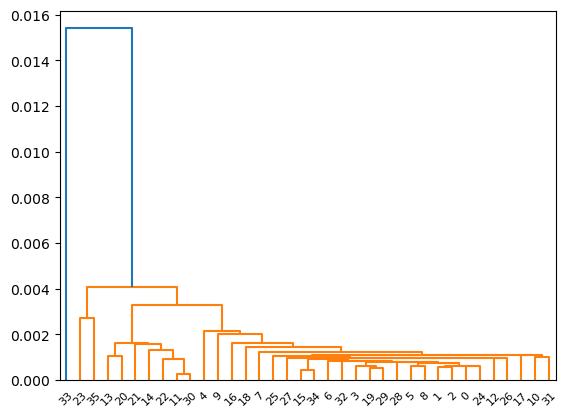

In [81]:
Z = sch.linkage(array, 'single')
dn = sch.dendrogram(Z)

In [82]:
comparisons[comparisons['window'] == 'chr1_1048576'].sort_values(by = 'divergence', ascending = False).reset_index()

,index,ind1,ind2,dyad_type,chr,window_start,window,mse,spearman,divergence,seq_diff
0,4151360,Dzeeta,Linda,ppn-pt,chr1,1048576,chr1_1048576,0.009066,0.963474,0.036526,2074
1,6465050,Negrita,Vincent,pts-ptt,chr1,1048576,chr1_1048576,0.008108,0.964242,0.035758,1648
2,1737507,Blanquita,Negrita,ptt,chr1,1048576,chr1_1048576,0.008014,0.964490,0.035510,1865
3,1702298,Blanquita,Linda,ptt-ptv,chr1,1048576,chr1_1048576,0.008154,0.964763,0.035237,2161
4,1422438,Bihati,Dzeeta,ppn-pt,chr1,1048576,chr1_1048576,0.009049,0.964935,0.035065,2606
...,...,...,...,...,...,...,...,...,...,...,...
1535,3339275,Clint,Julie-LWC21,pte-ptv,chr1,1048576,chr1_1048576,0.000082,0.999728,0.000272,1045
1536,2938373,Cindy-verus,Clint,ptv,chr1,1048576,chr1_1048576,0.000083,0.999736,0.000264,654
1537,5315494,Kidongo,Nakuu,pts,chr1,1048576,chr1_1048576,0.000078,0.999774,0.000226,1040
1538,1883408,Bono,Kombote,ppn,chr1,1048576,chr1_1048576,0.000050,0.999815,0.000185,866


In [83]:
def get_window_dendrogram(window):
    window_df = comparisons[comparisons['window'] == window]
    idx = sorted(set(window_df['ind1']).union(window_df['ind2']))
    array = window_df.pivot(index='ind1', columns='ind2', values='divergence').reindex(index=idx, columns=idx).fillna(0, downcast='infer').pipe(lambda x: x+x.values.T).to_numpy()
    condensed = pdist(array)
    
    fig, ax = plt.subplots(1, figsize=(8,8))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    condensed = pdist(array)
    
    plt.xlabel('Samples', fontproperties = arial) # label of the x-axis
    plt.ylabel('Euclidean distances', fontproperties = arial) # label of the y-axis
    plt.yticks(fontproperties = arial)
    
    plt.savefig('../plots/%s_tree.pdf' % (window), bbox_inches = 'tight', transparent = True)
    plt.show()
    
    return dendrogram

Using our IDWs as positive controls, can we discern IDWs and other patterns from hierarchical clustering?

Let's plot all 12 IDWs.

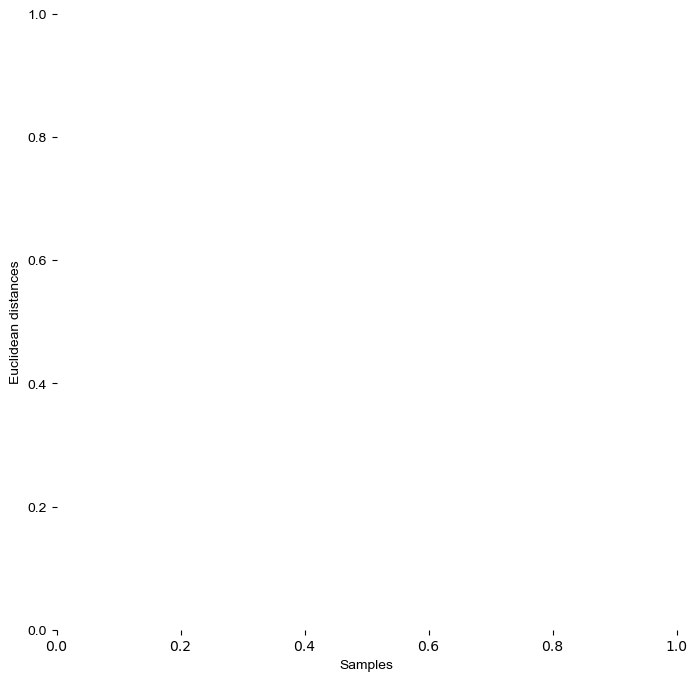

NameError: name 'dendrogram' is not defined

In [84]:
get_window_dendrogram('chr1_168820736')

In [ ]:
get_window_dendrogram('chr1_169345024')

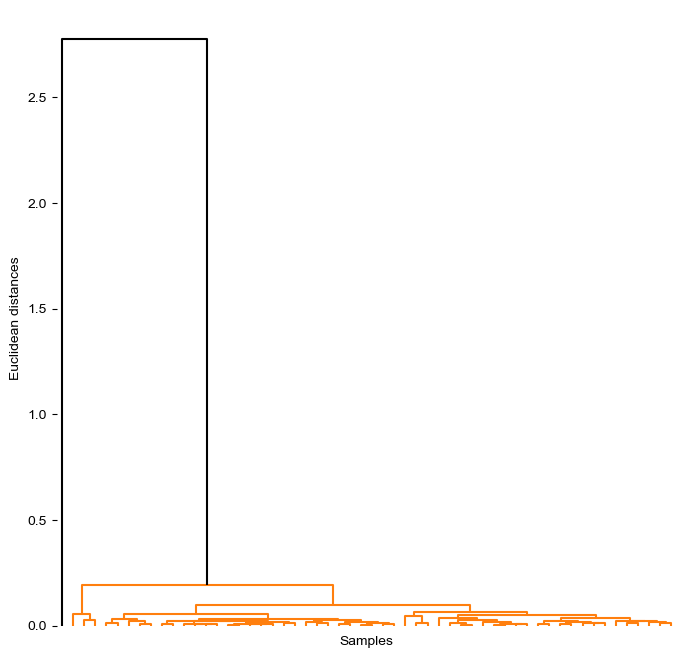

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [50.0, 50.0, 72.5, 72.5],
  [95.0, 95.0, 105.0, 105.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [115.0, 115.0, 132.5, 132.5],
  [155.0, 155.0, 165.0, 165.0],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [160.0, 160.0, 182.5, 182.5],
  [205.0, 205.0, 215.0, 215.0],
  [171.25, 171.25, 210.0, 210.0],
  [123.75, 123.75, 190.625, 190.625],
  [100.0, 100.0, 157.1875, 157.1875],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [255.0, 255.0, 265.0, 265.0],
  [275.0, 275.0, 285.0, 285.0],
  [295.0, 295.0, 305.0, 305.0],
  [280.0, 280.0, 300.0, 300.0],
  [260.0, 260.0, 290.0, 290.0],
  [232.5, 232.5, 275.0, 275.0],
  [128.59375, 128.59375, 253.75, 253.75],
  [61.25, 61.25, 191.171875, 191.171875],
  [325.0, 325.0, 335.0, 335.0],
  [315.0, 315.0, 330.0, 330.0],
  [365.0, 365.0, 375.0

In [73]:
get_window_dendrogram('chr2A_76021760')

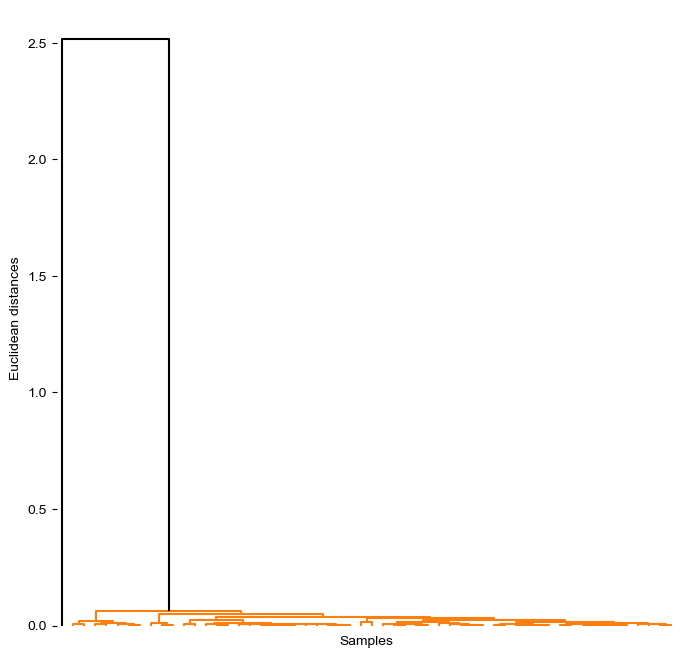

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [40.0, 40.0, 62.5, 62.5],
  [20.0, 20.0, 51.25, 51.25],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [115.0, 115.0, 125.0, 125.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [165.0, 165.0, 175.0, 175.0],
  [185.0, 185.0, 195.0, 195.0],
  [205.0, 205.0, 215.0, 215.0],
  [190.0, 190.0, 210.0, 210.0],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [235.0, 235.0, 252.5, 252.5],
  [225.0, 225.0, 243.75, 243.75],
  [200.0, 200.0, 234.375, 234.375],
  [170.0, 170.0, 217.1875, 217.1875],
  [142.5, 142.5, 193.59375, 193.59375],
  [120.0, 120.0, 168.046875, 168.046875],
  [275.0, 275.0, 285.0, 285.0],
  [305.0, 305.0, 315.0, 315.0],
  [325.0, 325.0, 335.0, 335.0],
  [310.0, 310.0, 330.0, 330.0],
  [295.0, 295.0, 320.0, 320.0],
  [375.0, 375.0, 385.0, 385.0],
  [365.0, 365.0, 380.0, 380.0],
  [355.0, 355.0, 372.5, 37

In [74]:
get_window_dendrogram('chr4_82837504')

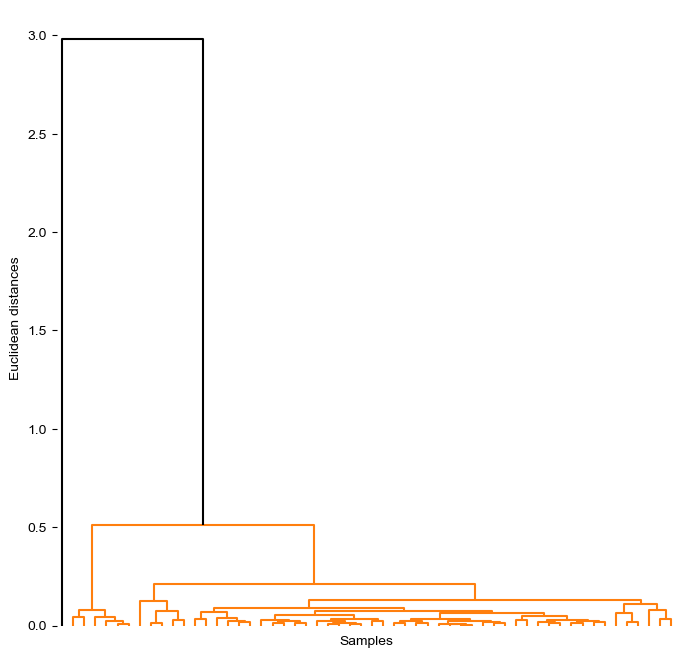

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [20.0, 20.0, 43.75, 43.75],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [90.0, 90.0, 110.0, 110.0],
  [75.0, 75.0, 100.0, 100.0],
  [125.0, 125.0, 135.0, 135.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [145.0, 145.0, 162.5, 162.5],
  [130.0, 130.0, 153.75, 153.75],
  [195.0, 195.0, 205.0, 205.0],
  [215.0, 215.0, 225.0, 225.0],
  [200.0, 200.0, 220.0, 220.0],
  [185.0, 185.0, 210.0, 210.0],
  [245.0, 245.0, 255.0, 255.0],
  [265.0, 265.0, 275.0, 275.0],
  [250.0, 250.0, 270.0, 270.0],
  [235.0, 235.0, 260.0, 260.0],
  [285.0, 285.0, 295.0, 295.0],
  [247.5, 247.5, 290.0, 290.0],
  [197.5, 197.5, 268.75, 268.75],
  [305.0, 305.0, 315.0, 315.0],
  [325.0, 325.0, 335.0, 335.0],
  [310.0, 310.0, 330.0, 330.0],
  [365.0, 365.0, 375.0, 375.0],
  [355.0, 355.0, 370.0, 370.0],
  [345.0, 345.0, 362.5, 362.5],
  [395.0, 395.0, 405

In [75]:
get_window_dendrogram('chr5_95420416')

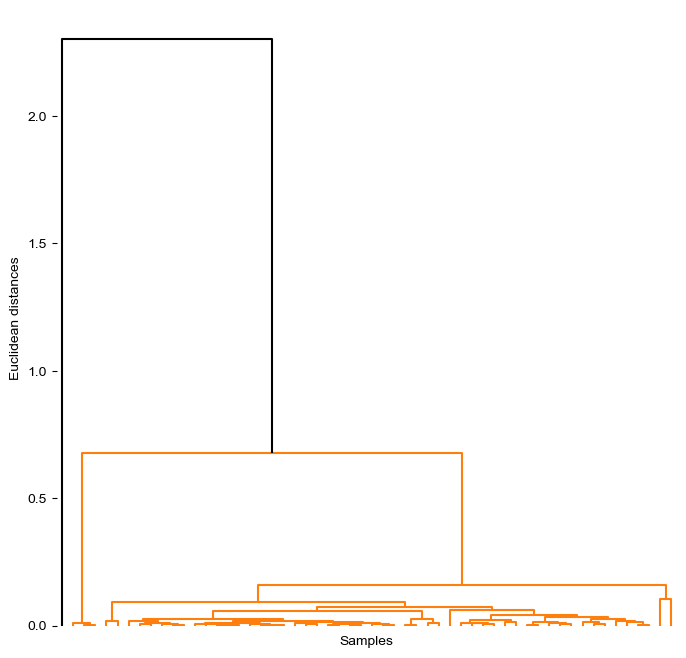

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [75.0, 75.0, 85.0, 85.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [80.0, 80.0, 102.5, 102.5],
  [65.0, 65.0, 91.25, 91.25],
  [155.0, 155.0, 165.0, 165.0],
  [145.0, 145.0, 160.0, 160.0],
  [135.0, 135.0, 152.5, 152.5],
  [125.0, 125.0, 143.75, 143.75],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [175.0, 175.0, 192.5, 192.5],
  [134.375, 134.375, 183.75, 183.75],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [245.0, 245.0, 255.0, 255.0],
  [265.0, 265.0, 275.0, 275.0],
  [250.0, 250.0, 270.0, 270.0],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [260.0, 260.0, 292.5, 292.5],
  [222.5, 222.5, 276.25, 276.25],
  [159.0625, 159.0625, 249.375, 249.375],
  [78.125, 78.125, 204.21875, 204.21875],
  [315.0, 315.0, 325.0, 325.0],
  [335.0, 335.0, 345.0, 345.0],
  [320.0, 320.0, 340.0, 340.0],
  [141.171875, 141.171

In [76]:
get_window_dendrogram('chr6_142606336')

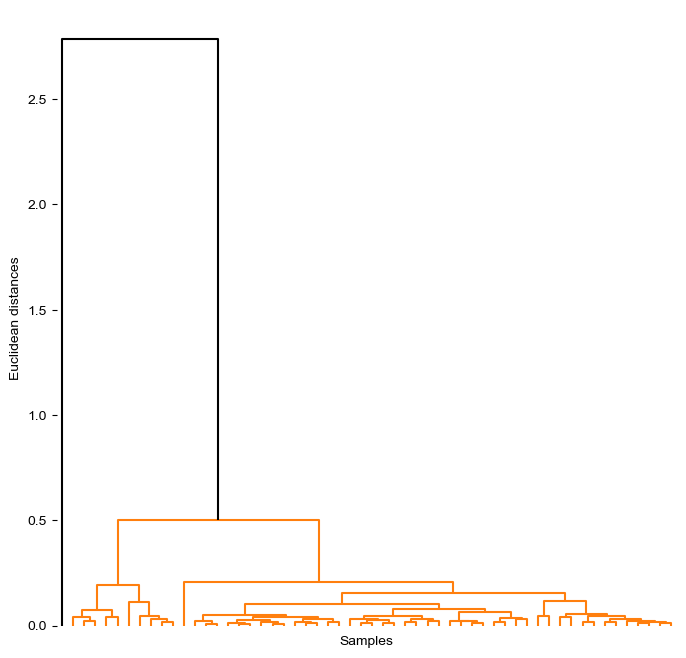

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [22.5, 22.5, 50.0, 50.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [75.0, 75.0, 92.5, 92.5],
  [65.0, 65.0, 83.75, 83.75],
  [36.25, 36.25, 74.375, 74.375],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [162.5, 162.5, 192.5, 192.5],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [245.0, 245.0, 255.0, 255.0],
  [222.5, 222.5, 250.0, 250.0],
  [177.5, 177.5, 236.25, 236.25],
  [132.5, 132.5, 206.875, 206.875],
  [275.0, 275.0, 285.0, 285.0],
  [295.0, 295.0, 305.0, 305.0],
  [280.0, 280.0, 300.0, 300.0],
  [265.0, 265.0, 290.0, 290.0],
  [315.0, 315.0, 325.0, 325.0],
  [335.0, 335.0, 345.0, 345.0],
  [320.0, 320.0, 340.0, 340.0],
  [277.5, 277.5, 330.0, 330.0],
  [375.0, 375.0, 385.0, 385.0],
  [365.0, 365.0,

In [77]:
get_window_dendrogram('chr7_105906176')

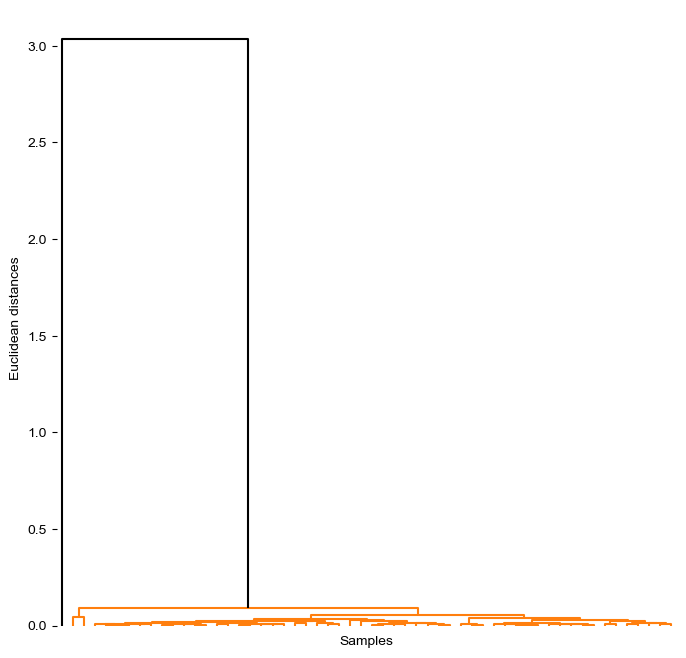

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [75.0, 75.0, 85.0, 85.0],
  [43.75, 43.75, 80.0, 80.0],
  [95.0, 95.0, 105.0, 105.0],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [100.0, 100.0, 122.5, 122.5],
  [61.875, 61.875, 111.25, 111.25],
  [145.0, 145.0, 155.0, 155.0],
  [165.0, 165.0, 175.0, 175.0],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [170.0, 170.0, 192.5, 192.5],
  [150.0, 150.0, 181.25, 181.25],
  [86.5625, 86.5625, 165.625, 165.625],
  [215.0, 215.0, 225.0, 225.0],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [220.0, 220.0, 242.5, 242.5],
  [126.09375, 126.09375, 231.25, 231.25],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [290.0, 290.0, 310.0, 310.0],
  [345.0, 345.0, 355.0, 355.0],
  [335.0, 335.0, 350.0, 350.0],
  [325.0, 325.0, 342.5, 342.5],
  [300.0, 300.0, 333.75, 333.75],
  [275.0, 275.0, 316.875, 31

In [78]:
get_window_dendrogram('chr8_112197632')

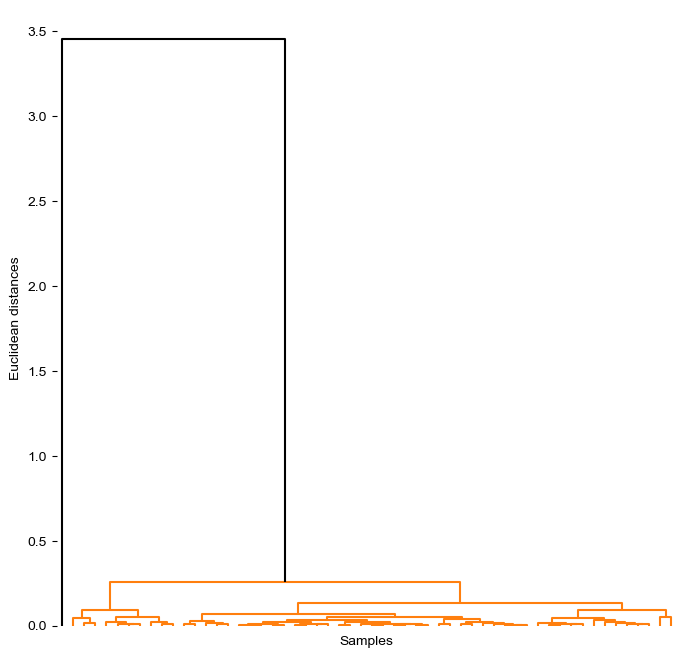

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [45.0, 45.0, 62.5, 62.5],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [53.75, 53.75, 92.5, 92.5],
  [22.5, 22.5, 73.125, 73.125],
  [115.0, 115.0, 125.0, 125.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [120.0, 120.0, 142.5, 142.5],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [195.0, 195.0, 205.0, 205.0],
  [172.5, 172.5, 200.0, 200.0],
  [215.0, 215.0, 225.0, 225.0],
  [235.0, 235.0, 245.0, 245.0],
  [220.0, 220.0, 240.0, 240.0],
  [186.25, 186.25, 230.0, 230.0],
  [255.0, 255.0, 265.0, 265.0],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [305.0, 305.0, 315.0, 315.0],
  [325.0, 325.0, 335.0, 335.0],
  [310.0, 310.0, 330.0, 330.0],
  [282.5, 282.5, 320.0, 320.0],
  [260.0, 260.0, 301.25, 301.25],
  [208.125, 208.125, 280.625, 280.625],
  [345.0, 345.0, 355.0, 355.0],
  [365.0, 36

In [79]:
get_window_dendrogram('chr8_128974848')

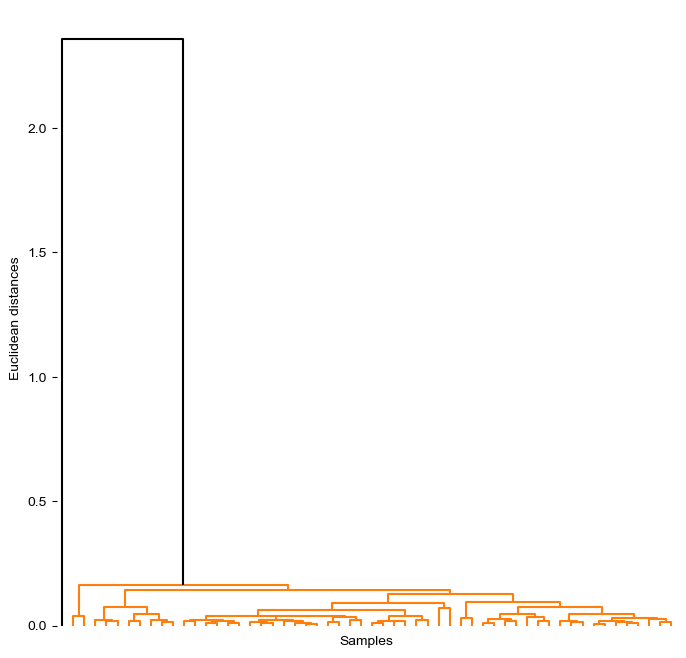

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [65.0, 65.0, 75.0, 75.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [70.0, 70.0, 92.5, 92.5],
  [42.5, 42.5, 81.25, 81.25],
  [115.0, 115.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [140.0, 140.0, 160.0, 160.0],
  [120.0, 120.0, 150.0, 150.0],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [205.0, 205.0, 222.5, 222.5],
  [182.5, 182.5, 213.75, 213.75],
  [245.0, 245.0, 255.0, 255.0],
  [265.0, 265.0, 275.0, 275.0],
  [250.0, 250.0, 270.0, 270.0],
  [198.125, 198.125, 260.0, 260.0],
  [135.0, 135.0, 229.0625, 229.0625],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [290.0, 290.0, 310.0, 310.0],
  [325.0, 325.0, 335.0, 335.0],
  [300.0, 300.0, 330.0, 330.0],
  [182.03125, 182.03125, 315.0, 315.0],
  [345.0, 345.0, 355.0, 355.0],
  [2

In [80]:
get_window_dendrogram('chr11_20971520')

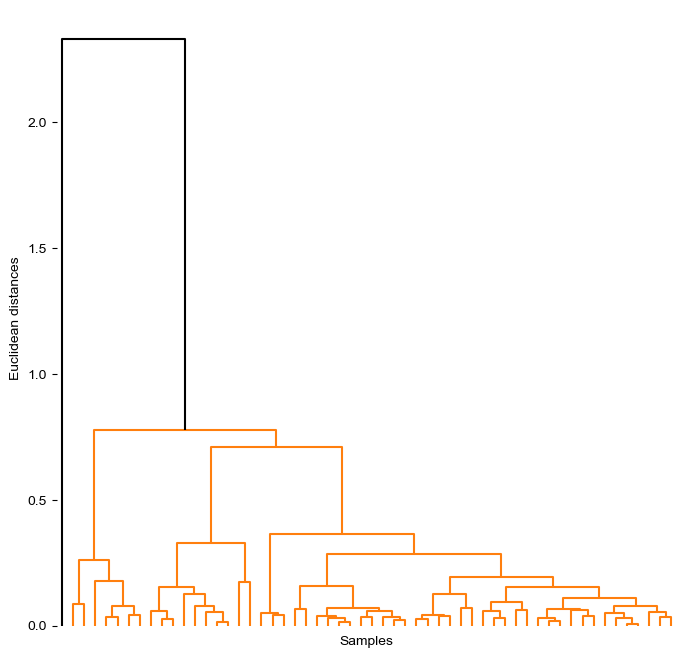

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [35.0, 35.0, 60.0, 60.0],
  [20.0, 20.0, 47.5, 47.5],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [125.0, 125.0, 142.5, 142.5],
  [115.0, 115.0, 133.75, 133.75],
  [92.5, 92.5, 124.375, 124.375],
  [165.0, 165.0, 175.0, 175.0],
  [108.4375, 108.4375, 170.0, 170.0],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [215.0, 215.0, 225.0, 225.0],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [235.0, 235.0, 252.5, 252.5],
  [275.0, 275.0, 285.0, 285.0],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [280.0, 280.0, 302.5, 302.5],
  [243.75, 243.75, 291.25, 291.25],
  [220.0, 220.0, 267.5, 267.5],
  [325.0, 325.0, 335.0, 335.0],
  [345.0, 345.0, 355.0, 355.0],
  [330.0, 330.0, 350.0, 350.0],
  [365.0, 365.0, 375.0, 375.0],
  [340.0, 34

In [81]:
get_window_dendrogram('chr14_26738688')

Now a random non-IDW window.

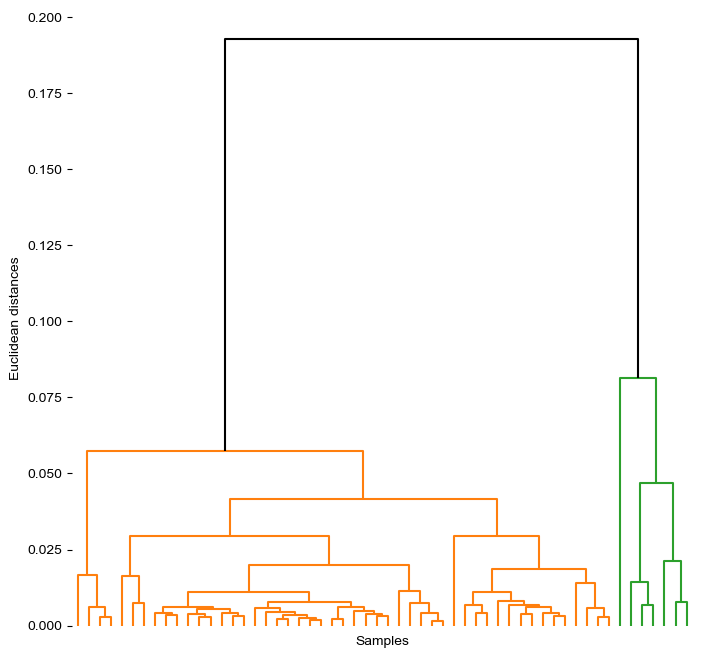

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [112.5, 112.5, 142.5, 142.5],
  [82.5, 82.5, 127.5, 127.5],
  [185.0, 185.0, 195.0, 195.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [190.0, 190.0, 212.5, 212.5],
  [175.0, 175.0, 201.25, 201.25],
  [165.0, 165.0, 188.125, 188.125],
  [235.0, 235.0, 245.0, 245.0],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [255.0, 255.0, 272.5, 272.5],
  [240.0, 240.0, 263.75, 263.75],
  [176.5625, 176.5625, 251.875, 251.875],
  [105.0, 105.0, 214.21875, 214.21875],
  [325.0, 325.0, 335.0, 335.0],
  [315.0, 315.0, 330.0, 330.0],
  [305.0, 305.0, 322.5, 322.5],
  [295.0, 295.0, 313.75, 313.75],
  [159.609375, 159.609375, 304.375

In [82]:
get_window_dendrogram('chr1_1048576')

In [ ]:
autosomal_average_linkage_trees = autosomal_average_linkage_trees.copy()
updated_trees['C0_count'] = updated_trees.apply(lambda row: row[row == 'C0'].count(), axis = 1)
updated_trees['C1_count'] = updated_trees.apply(lambda row: row[row == 'C1'].count(), axis = 1)
updated_trees['C2_count'] = updated_trees.apply(lambda row: row[row == 'C2'].count(), axis = 1)
updated_trees['C3_count'] = updated_trees.apply(lambda row: row[row == 'C3'].count(), axis = 1)
updated_trees['C4_count'] = updated_trees.apply(lambda row: row[row == 'C4'].count(), axis = 1)
updated_trees['C5_count'] = updated_trees.apply(lambda row: row[row == 'C5'].count(), axis = 1)
updated_trees['C6_count'] = updated_trees.apply(lambda row: row[row == 'C6'].count(), axis = 1)

In [112]:
single_linkage_trees = pd.read_csv('dataframes/single_linkage_clustering_per_window.txt', sep = '\t', header = None)
single_linkage_trees.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,chr10_1572864,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.005200,0.016430,0.016430,0.008743
1,chr10_2097152,C3,C2,C3,C3,C0,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C2,C3,C3,C3,C3,C3,C3,C2,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C1,C1,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,0.000000,0.030077,0.030077,0.028291
2,chr10_2621440,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.001941,0.004083,0.004083,0.002646
3,chr10_3145728,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.000000,0.002893,0.002893,0.001534
4,chr10_3670016,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C0,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.002369,0.008749,0.008749,0.007682


In [101]:
autosomal_single_linkage_trees = single_linkage_trees[~single_linkage_trees[0].str.startswith('chrX_')]
chrX_single_linkage_trees = single_linkage_trees[single_linkage_trees[0].str.startswith('chrX_')]

In [102]:
autosomal_single_linkage_trees_header = ['window','Akwaya-Jean','Alfred','Alice','Andromeda','Athanga','Berta','Bihati','Blanquita','Bono','Bosco','Brigitta','Bwamble','Cindy-schwein','Cindy-troglodytes','Cindy-verus','Cleo','Clint','Coco-chimp','Damian','Desmond','Doris','Dzeeta','Frederike','Gamin','Hermien','Hortense','Ikuru','Jimmie','Julie-A959','Julie-LWC21','Kidongo','Koby','Kombote','Kosana','Koto','Kumbuka','Lara','Linda','Luky','Marlin','Maya','Mgbadolite','Mirinda','Nakuu','Natalie','Negrita','SeppToni','Taweh','Tibe','Tongo','Trixie','Ula','Vaillant','Vincent','Washu','Yogui','node_0','node_1','node_2','node_3']
autosomal_single_linkage_trees.columns = autosomal_single_linkage_trees_header
autosomal_single_linkage_trees.head(5)

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3
0,chr10_1572864,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.005200,0.016430,0.016430,0.008743
1,chr10_2097152,C3,C2,C3,C3,C0,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C2,C3,C3,C3,C3,C3,C3,C2,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C1,C1,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,0.000000,0.030077,0.030077,0.028291
2,chr10_2621440,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.001941,0.004083,0.004083,0.002646
3,chr10_3145728,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.000000,0.002893,0.002893,0.001534
4,chr10_3670016,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C0,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.002369,0.008749,0.008749,0.007682


In [113]:
complete_linkage_trees = pd.read_csv('dataframes/complete_linkage_clustering_per_window.txt', sep = '\t', header = None)
complete_linkage_trees.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,chr10_1572864,C3,C3,C3,C2,C2,C3,C3,C2,C1,C3,C3,C2,C2,C3,C3,C2,C3,C2,C3,C1,C2,C1,C3,C3,C1,C1,C3,C3,C3,C3,C2,C3,C1,C1,C3,C1,C2,C3,C3,C3,C2,C2,C2,C2,C1,C2,C3,C3,C3,C2,C2,C3,C3,C2,C2,C2,0.014522,0.091748,0.091748,0.067514
1,chr10_2097152,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.038838,0.269334,0.269334,0.115208
2,chr10_2621440,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.005674,0.012824,0.012824,0.006737
3,chr10_3145728,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.002904,0.010145,0.010145,0.006418
4,chr10_3670016,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.005140,0.096248,0.096248,0.048080


In [114]:
autosomal_complete_linkage_trees = complete_linkage_trees[~complete_linkage_trees[0].str.startswith('chrX_')]
chrX_complete_linkage_trees = complete_linkage_trees[complete_linkage_trees[0].str.startswith('chrX_')]

In [115]:
autosomal_complete_linkage_trees_header = ['window','Akwaya-Jean','Alfred','Alice','Andromeda','Athanga','Berta','Bihati','Blanquita','Bono','Bosco','Brigitta','Bwamble','Cindy-schwein','Cindy-troglodytes','Cindy-verus','Cleo','Clint','Coco-chimp','Damian','Desmond','Doris','Dzeeta','Frederike','Gamin','Hermien','Hortense','Ikuru','Jimmie','Julie-A959','Julie-LWC21','Kidongo','Koby','Kombote','Kosana','Koto','Kumbuka','Lara','Linda','Luky','Marlin','Maya','Mgbadolite','Mirinda','Nakuu','Natalie','Negrita','SeppToni','Taweh','Tibe','Tongo','Trixie','Ula','Vaillant','Vincent','Washu','Yogui','node_0','node_1','node_2','node_3']
autosomal_complete_linkage_trees.columns = autosomal_complete_linkage_trees_header
autosomal_complete_linkage_trees.head(5)

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3
0,chr10_1572864,C3,C3,C3,C2,C2,C3,C3,C2,C1,C3,C3,C2,C2,C3,C3,C2,C3,C2,C3,C1,C2,C1,C3,C3,C1,C1,C3,C3,C3,C3,C2,C3,C1,C1,C3,C1,C2,C3,C3,C3,C2,C2,C2,C2,C1,C2,C3,C3,C3,C2,C2,C3,C3,C2,C2,C2,0.014522,0.091748,0.091748,0.067514
1,chr10_2097152,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.038838,0.269334,0.269334,0.115208
2,chr10_2621440,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.005674,0.012824,0.012824,0.006737
3,chr10_3145728,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.002904,0.010145,0.010145,0.006418
4,chr10_3670016,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.005140,0.096248,0.096248,0.048080


In [116]:
average_linkage_trees = pd.read_csv('dataframes/average_linkage_clustering_per_window.txt', sep = '\t', header = None)
average_linkage_trees.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,chr10_1572864,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.009356,0.053814,0.053814,0.023928
1,chr10_2097152,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.033565,0.111605,0.111605,0.054157
2,chr10_2621440,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.002646,0.007929,0.007929,0.004600
3,chr10_3145728,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.000000,0.005562,0.005562,0.003644
4,chr10_3670016,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.004355,0.029608,0.029608,0.017341


In [ ]:
autosomal_average_linkage_trees = complete_linkage_trees[~complete_linkage_trees[0].str.startswith('chrX_')]
chrX_average_linkage_trees = complete_linkage_trees[complete_linkage_trees[0].str.startswith('chrX_')]

Can we pick out the IDWs?

In [103]:
updated_trees = autosomal_single_linkage_trees.copy()
updated_trees['C0_count'] = updated_trees.apply(lambda row: row[row == 'C0'].count(), axis = 1)
updated_trees['C1_count'] = updated_trees.apply(lambda row: row[row == 'C1'].count(), axis = 1)
updated_trees['C2_count'] = updated_trees.apply(lambda row: row[row == 'C2'].count(), axis = 1)
updated_trees['C3_count'] = updated_trees.apply(lambda row: row[row == 'C3'].count(), axis = 1)
updated_trees['C4_count'] = updated_trees.apply(lambda row: row[row == 'C4'].count(), axis = 1)
updated_trees['C5_count'] = updated_trees.apply(lambda row: row[row == 'C5'].count(), axis = 1)
updated_trees['C6_count'] = updated_trees.apply(lambda row: row[row == 'C6'].count(), axis = 1)

In [87]:
#C0s = updated_trees[updated_trees.apply(lambda row: row.str.contains('C0', case=False).any(), axis=1)]

In [104]:
C0s = updated_trees[(updated_trees['C0_count'] == 1) & (updated_trees['C1_count'] == 55)]
C0s.head()

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3,C0_count,C1_count,C2_count,C3_count,C4_count,C5_count,C6_count
3,chr10_3145728,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.002893,0.002893,0.001534,1,55,0,0,0,0,0
11,chr10_8388608,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.059351,0.059351,0.024549,1,55,0,0,0,0,0
15,chr10_10485760,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.031188,0.031188,0.003103,1,55,0,0,0,0,0
16,chr10_11010048,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.011222,0.011222,0.002889,1,55,0,0,0,0,0
17,chr10_11534336,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.001389,0.001389,0.000757,1,55,0,0,0,0,0


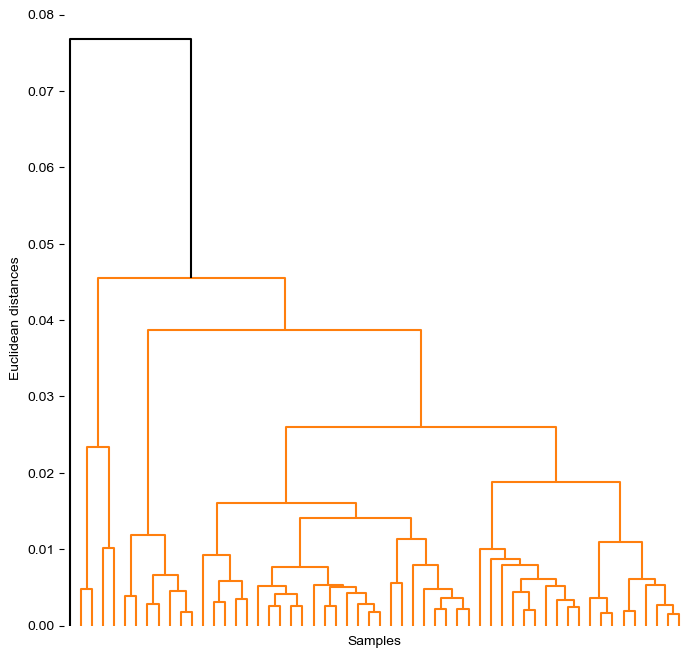

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [20.0, 20.0, 40.0, 40.0],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [80.0, 80.0, 102.5, 102.5],
  [60.0, 60.0, 91.25, 91.25],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [140.0, 140.0, 160.0, 160.0],
  [125.0, 125.0, 150.0, 150.0],
  [185.0, 185.0, 195.0, 195.0],
  [205.0, 205.0, 215.0, 215.0],
  [190.0, 190.0, 210.0, 210.0],
  [175.0, 175.0, 200.0, 200.0],
  [235.0, 235.0, 245.0, 245.0],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [255.0, 255.0, 272.5, 272.5],
  [240.0, 240.0, 263.75, 263.75],
  [225.0, 225.0, 251.875, 251.875],
  [187.5, 187.5, 238.4375, 238.4375],
  [295.0, 295.0, 305.0, 305.0],
  [335.0, 335.0, 345.0, 345.0],
  [355.0, 355.0, 365.0, 365.0],
  [340.0, 340.0, 360.0, 360.0],
  [325.0, 325.0, 350.0, 350.0],
  [315.0, 315.0, 337.5, 337.5],
  [300.0, 300.0, 326.25, 326.25],
  [212.968

In [94]:
get_window_dendrogram('chr10_20447232')

In [105]:
len(C0s)

1301

In [111]:
C0s[C0s['node_2'] - C0s['node_3'] > 0.01]

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3,C0_count,C1_count,C2_count,C3_count,C4_count,C5_count,C6_count
11,chr10_8388608,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.059351,0.059351,0.024549,1,55,0,0,0,0,0
15,chr10_10485760,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.031188,0.031188,0.003103,1,55,0,0,0,0,0
24,chr10_17301504,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.024824,0.024824,0.013999,1,55,0,0,0,0,0
29,chr10_20971520,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.014485,0.014485,0.002596,1,55,0,0,0,0,0
35,chr10_24117248,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.013004,0.013004,0.002875,1,55,0,0,0,0,0
36,chr10_24641536,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.020895,0.020895,0.010268,1,55,0,0,0,0,0
44,chr10_28835840,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.045050,0.045050,0.015766,1,55,0,0,0,0,0
45,chr10_29360128,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.054884,0.054884,0.015796,1,55,0,0,0,0,0
53,chr10_33554432,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,0.0,0.032311,0.032311,0.005692,1,55,0,0,0,0,0
55,chr10_34603008,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,0.016299,0.016299,0.003866,1,55,0,0,0,0,0


In [107]:
len(C0s[C0s['node_2'] > 2])

0

In [92]:
C0s[C0s['node_2'] > 2]

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3,C0_count,C1_count,C2_count,C3_count,C4_count,C5_count,C6_count
244,chr11_20447232,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,2.165120,2.165120,0.310892,1,55,0,0,0,0,0
245,chr11_20971520,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,2.358196,2.358196,0.162836,1,55,0,0,0,0,0
854,chr14_26738688,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,2.330871,2.330871,0.778521,1,55,0,0,0,0,0
927,chr14_66060288,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,2.563564,2.563564,1.233864,1,55,0,0,0,0,0
1359,chr18_46137344,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,2.281061,2.281061,1.100506,1,55,0,0,0,0,0
1360,chr18_46661632,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,2.339365,2.339365,1.573668,1,55,0,0,0,0,0
1383,chr18_58720256,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,2.147063,2.147063,1.162488,1,55,0,0,0,0,0
1588,chr1_72351744,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,2.441231,2.441231,0.101691,1,55,0,0,0,0,0
1640,chr1_103284736,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,2.128705,2.128705,0.319880,1,55,0,0,0,0,0
1731,chr1_168820736,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.0,4.839151,4.839151,0.713298,1,55,0,0,0,0,0


In [93]:
def lineage_checker(ppn_value,pte_value,pts_value,ptt_value,ptv_value):
    filtered_dataframe = autosomal_trees[
        (autosomal_trees['Akwaya-Jean'] == pte_value) &
        (autosomal_trees['Alfred'] == ptt_value) &
        (autosomal_trees['Alice'] == ptv_value) &
        (autosomal_trees['Andromeda'] == pts_value) &
        (autosomal_trees['Athanga'] == pts_value) &
        (autosomal_trees['Berta'] == ptv_value) &
        (autosomal_trees['Bihati'] == pts_value) &
        (autosomal_trees['Blanquita'] == ptt_value) &
        (autosomal_trees['Bono'] == ppn_value) &
        (autosomal_trees['Bosco'] == ptv_value) &
        (autosomal_trees['Brigitta'] == ptt_value) &
        (autosomal_trees['Bwamble'] == pts_value) &
        (autosomal_trees['Cindy-schwein'] == pts_value) &
        (autosomal_trees['Cindy-troglodytes'] == ptt_value) &
        (autosomal_trees['Cindy-troglodytes'] == ptt_value) &
        (autosomal_trees['Cindy-verus'] == ptv_value) &
        (autosomal_trees['Cleo'] == pts_value) &
        (autosomal_trees['Clint'] == ptv_value) &
        (autosomal_trees['Coco-chimp'] == pts_value) &
        (autosomal_trees['Damian'] == pte_value) &
        (autosomal_trees['Desmond'] == ppn_value) &
        (autosomal_trees['Doris'] == ptt_value) &
        (autosomal_trees['Dzeeta'] == ppn_value) &
        (autosomal_trees['Frederike'] == pts_value) &
        (autosomal_trees['Gamin'] == ptt_value) &
        (autosomal_trees['Hermien'] == ppn_value) &
        (autosomal_trees['Hortense'] == ppn_value) &
        (autosomal_trees['Ikuru'] == pts_value) &
        (autosomal_trees['Jimmie'] == ptv_value) &
        (autosomal_trees['Julie-A959'] == ptt_value) &
        (autosomal_trees['Julie-LWC21'] == pte_value) &
        (autosomal_trees['Kidongo'] == pts_value) &
        (autosomal_trees['Koby'] == ptv_value) &
        (autosomal_trees['Kombote'] == ppn_value) &
        (autosomal_trees['Kosana'] == ppn_value) &
        (autosomal_trees['Koto'] == pte_value) &
        (autosomal_trees['Kumbuka'] == ppn_value) &
        (autosomal_trees['Lara'] == ptt_value) &
        (autosomal_trees['Linda'] == ptv_value) &
        (autosomal_trees['Luky'] == ptt_value) &
        (autosomal_trees['Marlin'] == ptt_value) &
        (autosomal_trees['Maya'] == pts_value) &
        (autosomal_trees['Mgbadolite'] == pts_value) &
        (autosomal_trees['Mirinda'] == ptt_value) &
        (autosomal_trees['Nakuu'] == pts_value) &
        (autosomal_trees['Natalie'] == ppn_value) &
        (autosomal_trees['Negrita'] == ptt_value) &
        (autosomal_trees['SeppToni'] == ptv_value) &
        (autosomal_trees['Taweh'] == pte_value) &
        (autosomal_trees['Tibe'] == ptt_value) &
        (autosomal_trees['Tongo'] == pts_value) &
        (autosomal_trees['Trixie'] == pts_value) &
        (autosomal_trees['Ula'] == ptt_value) &
        (autosomal_trees['Vaillant'] == ptt_value) &
        (autosomal_trees['Vincent'] == pts_value) &
        (autosomal_trees['Washu'] == pts_value) &
        (autosomal_trees['Yogui'] == ptt_value)]
    
    return filtered_dataframe

In [79]:
thing = lineage_checker('C1','C2','C2','C2','C2')

In [80]:
len(thing)

132

In [81]:
thing_2 = lineage_checker('C2','C1','C1','C1','C1')

In [82]:
len(thing_2)

70

In [83]:
thing.head()

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3
0,chr10_1572864,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.130304,0.400507,0.400507,0.224271
57,chr10_35651584,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.057804,0.210214,0.210214,0.136894
115,chr10_72876032,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.035670,0.065715,0.065715,0.041650
122,chr10_78118912,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.060875,0.126010,0.126010,0.067519
123,chr10_78643200,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.094119,0.257062,0.257062,0.107602


In [86]:
thing_2.head()

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3
48,chr10_30932992,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.041040,0.111548,0.111548,0.052861
136,chr10_87031808,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.017369,0.101256,0.101256,0.020385
194,chr10_117440512,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.068920,0.130529,0.130529,0.084258
196,chr10_118489088,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.017553,0.036143,0.036143,0.019091
291,chr11_46137344,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.003930,0.008058,0.008058,0.004267


Previously called divergent window.

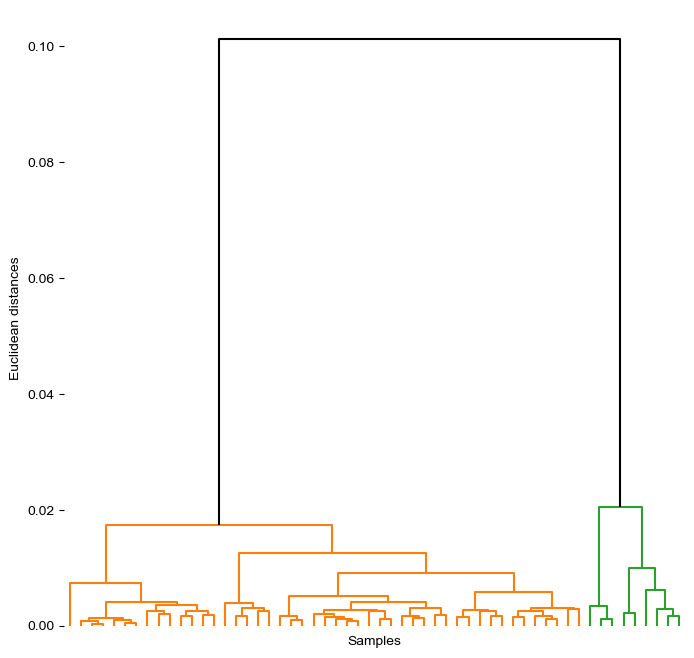

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [22.5, 22.5, 52.5, 52.5],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [105.0, 105.0, 115.0, 115.0],
  [125.0, 125.0, 135.0, 135.0],
  [110.0, 110.0, 130.0, 130.0],
  [82.5, 82.5, 120.0, 120.0],
  [37.5, 37.5, 101.25, 101.25],
  [5.0, 5.0, 69.375, 69.375],
  [155.0, 155.0, 165.0, 165.0],
  [175.0, 175.0, 185.0, 185.0],
  [160.0, 160.0, 180.0, 180.0],
  [145.0, 145.0, 170.0, 170.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [235.0, 235.0, 252.5, 252.5],
  [225.0, 225.0, 243.75, 243.75],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [234.375, 234.375, 282.5, 282.5],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [335.0, 335.0, 345.0, 345.0],
  [312.5, 312.5, 340.0, 340.0],
  [258.4375, 258.4375, 326.25, 326.25],
  [202.5, 202.5,

In [95]:
get_window_dendrogram('chr10_87031808')

New divergent window.

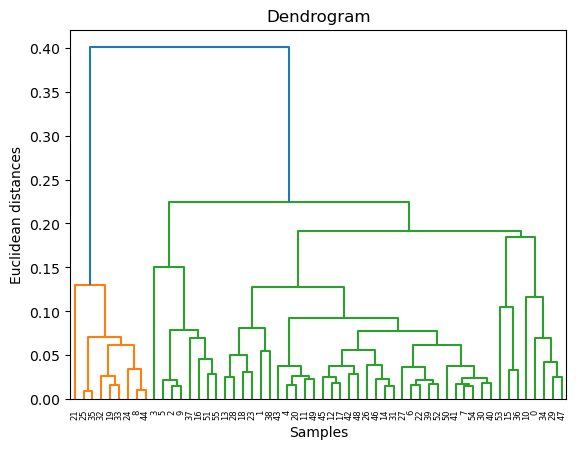

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [42.5, 42.5, 72.5, 72.5],
  [20.0, 20.0, 57.5, 57.5],
  [5.0, 5.0, 38.75, 38.75],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [155.0, 155.0, 165.0, 165.0],
  [145.0, 145.0, 160.0, 160.0],
  [135.0, 135.0, 152.5, 152.5],
  [112.5, 112.5, 143.75, 143.75],
  [95.0, 95.0, 128.125, 128.125],
  [175.0, 175.0, 185.0, 185.0],
  [195.0, 195.0, 205.0, 205.0],
  [180.0, 180.0, 200.0, 200.0],
  [215.0, 215.0, 225.0, 225.0],
  [190.0, 190.0, 220.0, 220.0],
  [245.0, 245.0, 255.0, 255.0],
  [265.0, 265.0, 275.0, 275.0],
  [250.0, 250.0, 270.0, 270.0],
  [235.0, 235.0, 260.0, 260.0],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [315.0, 315.0, 325.0, 325.0],
  [292.5, 292.5, 320.0, 320.0],
  [355.0, 355.0, 365.0, 365.0],
  [345.0, 345.0, 360.0, 360.0],
  [335.0, 335.0, 352.5, 352.5],
  [306.25, 306.25, 343.75,

In [90]:
get_window_dendrogram('chr10_1572864')

In [87]:
len(thing[thing['node_0'] > thing['node_3']])

0

In [91]:
len(thing_2[thing_2['node_3'] > thing_2['node_0']])

70

In [89]:
thing_2[thing_2['node_3'] > thing_2['node_0']]

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3
48,chr10_30932992,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.041040,0.111548,0.111548,0.052861
136,chr10_87031808,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.017369,0.101256,0.101256,0.020385
194,chr10_117440512,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.068920,0.130529,0.130529,0.084258
196,chr10_118489088,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.017553,0.036143,0.036143,0.019091
291,chr11_46137344,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.003930,0.008058,0.008058,0.004267
296,chr11_49807360,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.067642,0.139621,0.139621,0.071314
341,chr11_77070336,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.060916,0.318026,0.318026,0.092831
342,chr11_77594624,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.155786,0.648697,0.648697,0.161871
343,chr11_78118912,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.037523,0.079345,0.079345,0.041708
348,chr11_80740352,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C2,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.004750,0.017537,0.017537,0.010234


In [79]:
len(autosomal_trees)

4269

In [100]:
updated_trees = autosomal_trees.copy()
updated_trees['C0_count'] = updated_trees.apply(lambda row: row[row == 'C0'].index.tolist(), axis = 1)
updated_trees['C1_count'] = updated_trees.apply(lambda row: row[row == 'C1'].index.tolist(), axis = 1)
updated_trees['C2_count'] = updated_trees.apply(lambda row: row[row == 'C2'].index.tolist(), axis = 1)
updated_trees['C3_count'] = updated_trees.apply(lambda row: row[row == 'C3'].index.tolist(), axis = 1)
updated_trees['C4_count'] = updated_trees.apply(lambda row: row[row == 'C4'].index.tolist(), axis = 1)
updated_trees['C5_count'] = updated_trees.apply(lambda row: row[row == 'C5'].index.tolist(), axis = 1)
updated_trees['C6_count'] = updated_trees.apply(lambda row: row[row == 'C6'].index.tolist(), axis = 1)

In [94]:
IDWs_list = ['chr1_72351744','chr1_168820736','chr1_169345024','chr2A_76021760','chr4_82837504','chr5_95420416','chr6_142606336','chr7_105906176','chr8_112197632','chr8_128974848','chr11_20971520','chr14_26738688']

In [95]:
autosomal_trees[autosomal_trees['']

SyntaxError: incomplete input (3957355138.py, line 1)

In [ ]:
autosomal_trees[autosomal_trees.isin(IDWs_list).any(axis=1)]

In [96]:
summ = autosomal_trees[['Akwaya-Jean','Alfred','Alice','Andromeda','Athanga','Berta','Bihati','Blanquita','Bono','Bosco','Brigitta','Bwamble','Cindy-schwein','Cindy-troglodytes','Cindy-verus','Cleo','Clint','Coco-chimp','Damian','Desmond','Doris','Dzeeta','Frederike','Gamin','Hermien','Hortense','Ikuru','Jimmie','Julie-A959','Julie-LWC21','Kidongo','Koby','Kombote','Kosana','Koto','Kumbuka','Lara','Linda','Luky','Marlin','Maya','Mgbadolite','Mirinda','Nakuu','Natalie','Negrita','SeppToni','Taweh','Tibe','Tongo','Trixie','Ula','Vaillant','Vincent','Washu','Yogui']].stack().groupby(level=0).value_counts().unstack(fill_value=0)

In [97]:
summ

,C0,C1,C2,C3,C4,C5,C6
0,0,9,47,0,0,0,0
1,0,2,54,0,0,0,0
2,0,2,54,0,0,0,0
3,1,48,7,0,0,0,0
4,0,9,38,9,0,0,0
...,...,...,...,...,...,...,...
4264,0,4,52,0,0,0,0
4265,1,55,0,0,0,0,0
4266,0,2,54,0,0,0,0
4267,0,2,54,0,0,0,0


In [98]:
summ[(summ['C0'] == 1) & (summ['C1'] == 55)]

,C0,C1,C2,C3,C4,C5,C6
15,1,55,0,0,0,0,0
16,1,55,0,0,0,0,0
28,1,55,0,0,0,0,0
29,1,55,0,0,0,0,0
30,1,55,0,0,0,0,0
...,...,...,...,...,...,...,...
4248,1,55,0,0,0,0,0
4251,1,55,0,0,0,0,0
4255,1,55,0,0,0,0,0
4263,1,55,0,0,0,0,0


In [99]:
summ[(summ['C0'] == 55) & (summ['C1'] == 1)]

,C0,C1,C2,C3,C4,C5,C6


In [100]:
summ[(summ['C2'] == 1) & (summ['C1'] == 55)]

,C0,C1,C2,C3,C4,C5,C6


In [101]:
summ[(summ['C1'] == 1) & (summ['C2'] == 55)]

,C0,C1,C2,C3,C4,C5,C6


In [102]:
len(summ[(summ['C1'] == 9) & (summ['C2'] == 47)])

174

In [103]:
len(summ[(summ['C2'] == 9) & (summ['C1'] == 47)])

88

In [104]:
(174+88)/4420

0.05927601809954751

How many of these 174+88 match the bonobo/chimp split?

In [106]:
bonobo_list = ['Bono','Desmond','Dzeeta','Hermien','Hortense','Kombote','Kosana','Kumbuka','Natalie']
chimp_list = ['Akwaya-Jean','Alfred','Alice','Andromeda','Athanga','Berta','Bihati','Blanquita','Bosco','Brigitta','Bwamble','Cindy-schwein','Cindy-troglodytes','Cindy-verus','Cleo','Clint','Coco-chimp','Damian','Doris','Frederike','Gamin','Ikuru','Jimmie','Julie-A959','Julie-LWC21','Kidongo','Koby','Koto','Lara','Linda','Luky','Marlin','Maya','Mgbadolite','Mirinda','Nakuu','Natalie','Negrita','SeppToni','Taweh','Tibe','Tongo','Trixie','Ula','Vaillant','Vincent','Washu','Yogui']

In [108]:
autosomal_trees[autosomal_trees['Akwaya-Jean'] == 'C1']

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3
3,chr10_3145728,C1,C1,C1,C1,C2,C1,C2,C1,C1,C1,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C2,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,0.000000,0.033994,0.033994,0.026756
13,chr10_9437184,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,0.053045,0.094471,0.094471,0.060757
15,chr10_10485760,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.000000,0.304014,0.304014,0.047391
16,chr10_11010048,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.000000,0.095551,0.095551,0.033916
28,chr10_20447232,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,0.000000,0.076806,0.076806,0.045476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4256,chr9_102236160,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C2,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.011613,0.025147,0.025147,0.016748
4260,chr9_104333312,C1,C1,C2,C1,C1,C2,C1,C1,C1,C2,C1,C1,C1,C1,C2,C1,C2,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C2,C1,C1,C2,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.030346,0.070521,0.070521,0.035929
4263,chr9_105906176,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.000000,0.064038,0.064038,0.040493
4265,chr9_106954752,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,0.000000,0.050910,0.050910,0.032970


In [109]:
autosomal_trees['C1s'] = autosomal_trees.apply(lambda row: row[row == 'C1'].index, axis = 1)

/scratch/cbrand/ipykernel_45039/992616161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autosomal_trees['C1s'] = autosomal_trees.apply(lambda row: row[row == 'C1'].index, axis = 1)


In [110]:
autosomal_trees.head()

,window,Akwaya-Jean,Alfred,Alice,Andromeda,Athanga,Berta,Bihati,Blanquita,Bono,Bosco,Brigitta,Bwamble,Cindy-schwein,Cindy-troglodytes,Cindy-verus,Cleo,Clint,Coco-chimp,Damian,Desmond,Doris,Dzeeta,Frederike,Gamin,Hermien,Hortense,Ikuru,Jimmie,Julie-A959,Julie-LWC21,Kidongo,Koby,Kombote,Kosana,Koto,Kumbuka,Lara,Linda,Luky,Marlin,Maya,Mgbadolite,Mirinda,Nakuu,Natalie,Negrita,SeppToni,Taweh,Tibe,Tongo,Trixie,Ula,Vaillant,Vincent,Washu,Yogui,node_0,node_1,node_2,node_3,C1s
0,chr10_1572864,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.130304,0.400507,0.400507,0.224271,"Index(['Bono', 'Desmond', 'Dzeeta', 'Hermien',..."
1,chr10_2097152,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.146186,1.119267,1.119267,0.678716,"Index(['Luky', 'Marlin'], dtype='object')"
2,chr10_2621440,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,0.011953,0.055168,0.055168,0.026204,"Index(['Luky', 'Marlin'], dtype='object')"
3,chr10_3145728,C1,C1,C1,C1,C2,C1,C2,C1,C1,C1,C2,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,C0,C1,C2,C1,C1,C2,C1,C1,C1,C1,C1,C1,C1,C1,C2,C1,C1,C1,0.000000,0.033994,0.033994,0.026756,"Index(['Akwaya-Jean', 'Alfred', 'Alice', 'Andr..."
4,chr10_3670016,C2,C2,C2,C2,C2,C2,C2,C3,C1,C2,C2,C2,C2,C2,C2,C3,C2,C3,C3,C1,C2,C1,C2,C2,C1,C1,C2,C2,C2,C2,C2,C2,C1,C1,C3,C1,C2,C2,C2,C2,C3,C2,C2,C2,C1,C3,C2,C2,C2,C2,C3,C2,C2,C2,C3,C2,0.125900,0.311859,0.311859,0.234492,"Index(['Bono', 'Desmond', 'Dzeeta', 'Hermien',..."


## TADs

In [92]:
TADs_header = ['chr','start','end','score','C3624_overlap','C3649_overlap','C3651_overlap','C40300_overlap']
TADs = pd.read_csv('annotations/panTro6_TADs.bed', sep = '\t', header = None, names = TADs_header)
TADs.head(5)

,chr,start,end,score,C3624_overlap,C3649_overlap,C3651_overlap,C40300_overlap
0,chr1,394452,543414,1.022634,150000,150000,150000,150000
1,chr1,553368,720938,0.825499,0,140000,140000,0
2,chr1,1404000,2025870,1.463877,350000,520000,520000,540000
3,chr1,2426223,4649193,1.823161,2080000,1630000,2090000,2060000
4,chr1,2500179,3198029,1.480341,710000,260000,710000,710000


In [93]:
len(TADs)

7812

In [108]:
TADs.groupby(['chr'])['score'].count().to_frame('N')

,N
chr,
chr1,737
chr10,405
chr11,408
chr12,389
chr13,265
chr14,279
chr15,264
chr16,216
chr16_NW_019932886v1_random,4


In [94]:
TAD_lengths = TADs['end'] - TADs['start']
TAD_lengths

0        148962
1        167570
2        621870
3       2222970
4        697850
         ...   
7807     681211
7808     157817
7809     269993
7810     219993
7811     197097
Length: 7812, dtype: int64

In [95]:
TAD_lengths.mean()

445882.1714029698

In [96]:
TAD_lengths.median()

299426.0

Many of these TADs appear to be nested. Let's merge them. First, read in the TADs file using pybedtools.

In [97]:
TADs_BED = pybedtools.BedTool('annotations/panTro6_TADs.bed')
merged_TADs_BED = TADs_BED.merge()

In [98]:
len(merged_TADs_BED)

2853

In [102]:
merged_TADs = merged_TADs_BED.to_dataframe(names=['chr','start','end'])
merged_TADs_lengths = merged_TADs['end'] = merged_TADs['start']

In [103]:
merged_TADs_lengths.mean()

67910578.58114266

In [104]:
merged_TADs_lengths.median()

58602004.0

Save these merged TADs.

In [109]:
TADs.saveas('annotations/merged_TADs.bed')

## Lineage Comparison <a class = 'anchor' id = 'lineagecomparison'></a>

Let's count the number of dyads.

In [136]:
comparisons.groupby('dyad_type').size().to_frame('N').sort_values(by = 'N', ascending = False)

,N
dyad_type,
ppn-pt,1836440
pts-ptt,1179439
pts-ptv,661462
ptt-ptv,623041
pts,588889
ptt,520585
pte-pts,366187
pte-ptt,344842
pte-ptv,193615


In [137]:
1173727+658249+620017+364402+343162+192670

3352227

Create a genome-wide average per dyad.

In [138]:
genome_wide_means = comparisons[['ind1','ind2','dyad_type','divergence']]
genome_wide_means = genome_wide_means.groupby(['ind1','ind2']).agg({'dyad_type':'first', 'divergence':'mean'}).reset_index()
genome_wide_means.head(5)

,ind1,ind2,dyad_type,divergence
0,Akwaya-Jean,Alfred,pte-ptt,0.007259
1,Akwaya-Jean,Alice,pte-ptv,0.005879
2,Akwaya-Jean,Andromeda,pte-pts,0.006831
3,Akwaya-Jean,Athanga,pte-pts,0.007520
4,Akwaya-Jean,Berta,pte-ptv,0.005879


In [139]:
genome_wide_means.groupby('dyad_type')['divergence'].mean().to_frame('mean')

,mean
dyad_type,
ppn,0.003259
ppn-pt,0.011213
pte,0.004617
pte-pts,0.007213
pte-ptt,0.007453
pte-ptv,0.006084
pts,0.005409
pts-ptt,0.006966
pts-ptv,0.007378


In [140]:
genome_wide_means['dyad_type'] = genome_wide_means['dyad_type'].replace({'pte-pts':'pt-pt', 'pte-ptt':'pt-pt', 'pte-ptv':'pt-pt', 'pts-ptt':'pt-pt', 'pts-ptv':'pt-pt', 'ptt-ptv':'pt-pt'})

In [141]:
genome_wide_means.groupby('dyad_type')['divergence'].mean().to_frame('mean')

,mean
dyad_type,
ppn,0.003259
ppn-pt,0.011213
pt-pt,0.007210
pte,0.004617
pts,0.005409
ptt,0.006829
ptv,0.002696


## Divergent Windows <a class = 'anchor' id = 'divergentwindows'></a>

Let's identify windows where the divergence between bonobos and chimpanzees exceeds that of all other dyads (except for within-bonobo variation). Write a function to begin just in case we need this again.

In [107]:
def get_divergent_windows(target, ignored):
    subset = comparisons[~comparisons['dyad_type'].isin(ignored)]
    others_maxes = subset[~subset['dyad_type'].isin(target)].groupby(['window'])['divergence'].max().to_frame('max').reset_index()
    target_mins = subset[subset['dyad_type'].isin(target)].groupby(['window'])['divergence'].min().to_frame('min').reset_index()
    all_windows = pd.merge(others_maxes, target_mins, on = 'window')
    divergent_windows = all_windows[all_windows['min'] > all_windows['max']]
    
    return divergent_windows

Apply the function.

In [108]:
divergent_windows = get_divergent_windows(['ppn-pt'], ['ppn'])
divergent_windows.head(5)

,window,max,min
180,chr10_87031808,0.002229,0.008621
181,chr10_87556096,0.004172,0.026767
389,chr11_77070336,0.014929,0.023994
390,chr11_77594624,0.018620,0.050357
547,chr12_44040192,0.039008,0.054170


How many windows are divergent between bonobos and chimpanzees?

In [109]:
len(divergent_windows)

65

Make a quick list of these windows.

In [110]:
divergent_windows_list = divergent_windows['window'].tolist()

Make a dictionary from the maxes here using the window as the index. We'll need them for identifying 3d-modifying variants.

In [146]:
divergent_window_chimp_maxes = pd.Series(divergent_windows['max'].values, index = divergent_windows['window']).to_dict()

Let's go ahead and split the first column but keep the window column.

In [147]:
divergent_windows['window_split'] = divergent_windows['window']
divergent_windows = divergent_windows['window_split'].str.split('_', expand=True)
divergent_windows.rename(columns = {0:'chr', 1:'window_start'}, inplace = True)
divergent_windows.head(5)

,chr,window_start
180,chr10,87031808
181,chr10,87556096
389,chr11,77070336
390,chr11,77594624
547,chr12,44040192


Let's output these divergent windows. 

In [148]:
divergent_windows['window_start'] = divergent_windows['window_start'].astype(int)

In [149]:
divergent_windows['window_end'] = divergent_windows['window_start'] + 1048576
divergent_windows.head(5)

,chr,window_start,window_end
180,chr10,87031808,88080384
181,chr10,87556096,88604672
389,chr11,77070336,78118912
390,chr11,77594624,78643200
547,chr12,44040192,45088768


Note that we do not need to convert the start coordinate here because the windows are already in 0-based coordinates.

In [150]:
divergent_windows.to_csv('divergent_windows/ppn_pt_divergent_windows.bed', sep = '\t', header = False, index = False)

Do any of these windows occur on chromosome 7? The Eres et al. 2019 TAD dataset did not include any TADs from chromosome 7.

In [151]:
chr7_divergent_windows = divergent_windows[divergent_windows['chr'] == 'chr7']
chr7_divergent_windows

,chr,window_start,window_end
3714,chr7,14680064,15728640
3722,chr7,15204352,16252928
3745,chr7,24117248,25165824
3830,chr7,83886080,84934656
3831,chr7,84410368,85458944


### Divergent Windows: In Silico Mutagenesis <a class = 'anchor' id = 'divergentwindowsinsilicomutagenesis'></a>

What variants are driving these patterns? Let's examine the results of in silico mutagenesis in divergent windows using bonobo-specific variants. 

In [152]:
in_silico_ppn_pt = pd.read_csv('in_silico_mutagenesis/ppn_pt_variants.txt', sep = '\t', header = 0)
in_silico_ppn_pt.head(5)

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
0,chr1,126353856,126353408,C,T,6.056359e-09,1.303497e-08,2.141693e-08
1,chr1,126354684,126353408,C,T,5.633056e-10,1.316873e-09,2.658624e-09
2,chr1,126357977,126353408,T,C,1.889719e-09,3.938154e-09,6.916280e-09
3,chr1,126358737,126353408,C,T,1.359774e-09,3.207846e-09,5.962348e-09
4,chr1,126361540,126353408,G,T,4.042944e-10,8.747596e-10,1.930460e-09


In [153]:
len(in_silico_ppn_pt)

87968

Let's edit the window column to also include the chromosome. 

In [154]:
in_silico_ppn_pt['window'] = in_silico_ppn_pt['chr'] + '_' + in_silico_ppn_pt['window'].astype(str)
in_silico_ppn_pt.head(5)

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
0,chr1,126353856,chr1_126353408,C,T,6.056359e-09,1.303497e-08,2.141693e-08
1,chr1,126354684,chr1_126353408,C,T,5.633056e-10,1.316873e-09,2.658624e-09
2,chr1,126357977,chr1_126353408,T,C,1.889719e-09,3.938154e-09,6.916280e-09
3,chr1,126358737,chr1_126353408,C,T,1.359774e-09,3.207846e-09,5.962348e-09
4,chr1,126361540,chr1_126353408,G,T,4.042944e-10,8.747596e-10,1.930460e-09


Now map these values to the windows in the in silico mutagenesis dataframe.

In [155]:
in_silico_ppn_pt['empirical_max'] = in_silico_ppn_pt['window'].map(divergent_window_chimp_maxes)
in_silico_ppn_pt.head(5)

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman,empirical_max
0,chr1,126353856,chr1_126353408,C,T,6.056359e-09,1.303497e-08,2.141693e-08,0.014749
1,chr1,126354684,chr1_126353408,C,T,5.633056e-10,1.316873e-09,2.658624e-09,0.014749
2,chr1,126357977,chr1_126353408,T,C,1.889719e-09,3.938154e-09,6.916280e-09,0.014749
3,chr1,126358737,chr1_126353408,C,T,1.359774e-09,3.207846e-09,5.962348e-09,0.014749
4,chr1,126361540,chr1_126353408,G,T,4.042944e-10,8.747596e-10,1.930460e-09,0.014749


Which variants cause a 3D change that is greater or equal to the observed maximum difference in chimpanzees?

In [156]:
ppn_pt_3d_modifying_variants = in_silico_ppn_pt[in_silico_ppn_pt['1-spearman'] >= in_silico_ppn_pt['empirical_max']]
ppn_pt_3d_modifying_variants

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman,empirical_max
651,chr1,126940560,chr1_126353408,C,G,0.011125,0.028504,0.036647,0.014749
2145,chr1,153901388,chr1_153092096,A,T,0.004234,0.010179,0.012604,0.008637
2146,chr1,153901388,chr1_153616384,A,T,0.005189,0.013755,0.017142,0.007771
3306,chr1,178484674,chr1_178257920,G,A,0.002513,0.004524,0.004877,0.002564
6029,chr10,87896916,chr10_87031808,A,G,0.004084,0.008674,0.008403,0.002229
6030,chr10,87896916,chr10_87556096,A,G,0.004272,0.005520,0.005186,0.004172
6408,chr10,88057593,chr10_87556096,G,C,0.018322,0.034889,0.031364,0.004172
6410,chr10,88057595,chr10_87556096,G,T,0.019119,0.036460,0.032893,0.004172
9391,chr11,77997697,chr11_77070336,G,A,0.002093,0.013661,0.025199,0.014929
9392,chr11,77997697,chr11_77594624,G,A,0.007758,0.055782,0.069116,0.018620


In [157]:
len(ppn_pt_3d_modifying_variants)

59

Let's create a BED file of the variants to complete intersections we will complete in the following steps.

In [158]:
ppn_pt_3d_modifying_variants_BED = ppn_pt_3d_modifying_variants[['chr','pos']].copy()
ppn_pt_3d_modifying_variants_BED.rename(columns={ ppn_pt_3d_modifying_variants_BED.columns[1]: 'end' }, inplace = True)
ppn_pt_3d_modifying_variants_BED['start'] = ppn_pt_3d_modifying_variants_BED['end'].astype(int)-1
ppn_pt_3d_modifying_variants_BED = ppn_pt_3d_modifying_variants_BED[['chr','start','end']]
ppn_pt_3d_modifying_variants_BED = ppn_pt_3d_modifying_variants_BED.drop_duplicates()
ppn_pt_3d_modifying_variants_BED.head(5)

,chr,start,end
651,chr1,126940559,126940560
2145,chr1,153901387,153901388
3306,chr1,178484673,178484674
6029,chr10,87896915,87896916
6408,chr10,88057592,88057593


In [159]:
len(ppn_pt_3d_modifying_variants_BED)

46

We will be shuffling these variants in our phenotype enrichment momentarily so go ahead and save the frame.

In [160]:
ppn_pt_3d_modifying_variants_BED.to_csv('divergent_windows/ppn_pt_3d_modifying_variants.bed', sep = '\t', header = False, index = False)

### Divergent Windows: TADs <a class = 'anchor' id = 'divergentwindowsTADs'></a>

Now let's intersect variants with panTro6 TADs. Load the TADs and variants from above as BedTool objects.

In [161]:
#TADs = pybedtools.BedTool('annotations/panTro6_TADs.bed')
#TADs.head()

In [162]:
#len(TADs)

Many of these TADs are nested. Let's go ahead and merge them all for these next few steps as we only care whether or not modifying variants fall within any TAD.

In [163]:
#TADs = TADs.merge()

In [164]:
#len(TADs)

Save these merged TADs.

In [165]:
#TADs.saveas('annotations/merged_TADs.bed')

Load merged TADs.

In [166]:
TADs = pybedtools.BedTool('annotations/merged_TADs.bed')
TADs.head()

chr1	394452	543414
 chr1	553368	720938
 chr1	1404000	2025870
 chr1	2426223	4649193
 chr1	5186977	6658207
 chr1	7145034	7544896
 chr1	7807327	7946750
 chr1	7966773	8185800
 chr1	8426532	8576470
 chr1	9191208	9682756
 

In [167]:
variants = pybedtools.BedTool().from_dataframe(ppn_pt_3d_modifying_variants_BED).sort()
variants.head()

chr1	126940559	126940560
 chr1	153901387	153901388
 chr1	178484673	178484674
 chr10	87896915	87896916
 chr10	88057592	88057593
 chr10	88057594	88057595
 chr11	77997696	77997697
 chr12	44497511	44497512
 chr13	30853022	30853023
 chr13	46009274	46009275
 

In [168]:
len(variants)

46

Intersect.

In [169]:
TAD_variant_intersection = TADs.intersect(variants, u = True)
TAD_variant_intersection.head(5)

chr1	153667973	154171572
 chr1	178233482	180756832
 chr10	87740775	87979469
 chr10	88039334	88432538
 chr11	77365770	78464824
 

In [170]:
len(TAD_variant_intersection)

30

Intersect again and use the 'wo' flag to output TADs per overlapping variant. We will need this to get our gene list shortly.

In [171]:
TAD_variant_intersection = TADs.intersect(variants, wo = True)
TAD_variant_intersection.head(5)

chr1	153667973	154171572	chr1	153901387	153901388	1
 chr1	178233482	180756832	chr1	178484673	178484674	1
 chr10	87740775	87979469	chr10	87896915	87896916	1
 chr10	88039334	88432538	chr10	88057592	88057593	1
 chr10	88039334	88432538	chr10	88057594	88057595	1
 

In [172]:
len(TAD_variant_intersection)

31

### Divergent Windows: Genes <a class = 'anchor' id = 'divergentwindowsgenes'></a>

Now that we have TADs that include at least one 3D modifying variant, let's grab the genes that fall within those TADs. Load the genes as a BedTool object.

In [173]:
genes = pybedtools.BedTool('annotations/panTro6_genes.bed')
genes.head(5)

chr1	344	12299	NM_001280424.1	INTS11
 chr1	12400	16513	XM_016952033.2	CPTP
 chr1	17887	23426	XM_003307748.4	TAS1R3
 chr1	22943	36942	XM_016958290.2	DVL1
 chr1	39619	45507	NM_001280245.1	MXRA8
 

In [174]:
len(genes)

20908

Intersect and save the result.

In [175]:
gene_TAD_intersection = genes.intersect(TAD_variant_intersection, wa = True, wb = True).to_dataframe(names=['gene_chr','gene_start','gene_end','transcript','gene','TAD_chr','TAD_start','TAD_end','variant_chr','variant_start','variant_end','count'])
gene_TAD_intersection.head(5)

,gene_chr,gene_start,gene_end,transcript,gene,TAD_chr,TAD_start,TAD_end,variant_chr,variant_start,variant_end,count
0,chr1,153652385,153672636,XM_016933233.1,TEX35,chr1,153667973,154171572,chr1,153901387,153901388,1
1,chr1,153858451,154045736,XM_001155266.6,RALGPS2,chr1,153667973,154171572,chr1,153901387,153901388,1
2,chr1,153973582,153996238,XM_001155648.4,ANGPTL1,chr1,153667973,154171572,chr1,153901387,153901388,1
3,chr1,154144709,154193465,XM_024350291.1,FAM20B,chr1,153667973,154171572,chr1,153901387,153901388,1
4,chr1,178222809,178240279,XM_009440162.3,TMEM183A,chr1,178233482,180756832,chr1,178484673,178484674,1


In [176]:
len(gene_TAD_intersection)

166

In [177]:
divergent_genes = gene_TAD_intersection['gene']
divergent_genes = divergent_genes.sort_values(ascending = True).to_frame('gene')
divergent_genes.head(5)

,gene
150,ADGRF1
149,ADGRF5
7,ADORA1
128,ALCAM
2,ANGPTL1


In [178]:
divergent_genes.to_csv('divergent_windows/ppn_pt_genes_with_3d_modifying_variants.txt', sep = '\t', header = False, index = False)

### Divergent Windows: Differential Gene Expression <a class = 'anchor' id = 'divergentwindowsexpression'></a>

Let's consider whether genes topologically associated with 3d modifying variants between bonobos and chimpanzees exhibit differential gene expression. Download the SRA data from Brawand et al. 2011 and run the RNAseq pipeline to generate read counts per gene per sample. Below we will gather and analyze these data. 

Write a tissue dictionary.

In [97]:
tissue_dict = dict({'SRR306811': 'prefrontal_cortex',
                 'SRR306817': 'cerebellum',
                 'SRR306818': 'cerebellum', 
                 'SRR306819': 'heart', 
                 'SRR306820': 'heart', 
                 'SRR306821': 'kidney', 
                 'SRR306822': 'kidney', 
                 'SRR306823': 'liver', 
                 'SRR306824': 'liver', 
                 'SRR306825': 'testis',
                 'SRR306827': 'prefrontal_cortex',
                 'SRR306828': 'prefrontal_cortex',
                 'SRR306829': 'cerebellum',
                 'SRR306830': 'cerebellum', 
                 'SRR306831': 'heart', 
                 'SRR306832': 'heart', 
                 'SRR306833': 'kidney', 
                 'SRR306834': 'kidney', 
                 'SRR306835': 'liver', 
                 'SRR306836': 'liver', 
                 'SRR306837': 'testis'})

Define which samples belong to which individual.

In [98]:
ppn_female = ['SRR306827','SRR306829','SRR306831','SRR306833','SRR306835']
ppn_male = ['SRR306828','SRR306830','SRR306832','SRR306834','SRR306836','SRR306837']
ptr_female = ['SRR306811','SRR306817','SRR306819','SRR306821','SRR306823']
ptr_male = ['SRR306818','SRR306820','SRR306822','SRR306824','SRR306825']

Now let's write a function to gather the read count data per individual.

In [99]:
def reads_per_individual(individual, SRR_ids_list):
    individual_read_counts_dfs_list = []
    
    for i in range(len(SRR_ids_list)):
        individual_temp_df = pd.read_csv('RNAseq/read_counts/'+SRR_ids_list[i]+'_read_counts.txt', sep = '\t', names = ['gene',SRR_ids_list[i]])
        individual_read_counts_dfs_list.append(individual_temp_df)
        
    for df in individual_read_counts_dfs_list:
        df.set_index('gene', inplace = True)
        
    individual_read_counts_df = pd.concat(individual_read_counts_dfs_list, axis = 1, sort = False).reset_index()
    
    individual_read_counts_df = individual_read_counts_df.set_index(['gene']).stack().to_frame().reset_index()
    individual_read_counts_df.rename(columns={ 'level_1': 'sample', 0: individual}, inplace = True)
    individual_read_counts_df['tissue'] = individual_read_counts_df['sample'].map(tissue_dict)
    individual_read_counts_df = individual_read_counts_df.drop('sample', axis = 1)
    individual_read_counts_df = individual_read_counts_df[~individual_read_counts_df['gene'].str.startswith('_')]
    individual_read_counts_df = individual_read_counts_df[~individual_read_counts_df['gene'].str.startswith('unassigned')]
    individual_read_counts_df = individual_read_counts_df[['gene','tissue',individual]]
    
    return individual_read_counts_df

Apply the function to all four individuals.

In [100]:
ppn_female_reads = reads_per_individual('ppn_female', ppn_female).set_index(['gene','tissue'])
ppn_male_reads = reads_per_individual('ppn_male', ppn_male).set_index(['gene','tissue'])
ptr_female_reads = reads_per_individual('ptr_female', ptr_female).set_index(['gene','tissue'])
ptr_male_reads = reads_per_individual('ptr_male', ptr_male).set_index(['gene','tissue'])

Gather those data and check out the dataframe.

In [101]:
gene_expression = pd.concat([ppn_female_reads, ppn_male_reads, ptr_female_reads, ptr_male_reads], axis = 1, sort = False).reset_index()
gene_expression.head(12)

,gene,tissue,ppn_female,ppn_male,ptr_female,ptr_male
0,A1BG,prefrontal_cortex,57.0,19,25.0,NaN
1,A1BG,cerebellum,77.0,106,33.0,60.0
2,A1BG,heart,10.0,13,1.0,2.0
3,A1BG,kidney,71.0,41,4.0,47.0
4,A1BG,liver,20096.0,7430,14688.0,26935.0
5,A1CF,prefrontal_cortex,0.0,0,0.0,NaN
6,A1CF,cerebellum,0.0,0,0.0,2.0
7,A1CF,heart,0.0,1,0.0,0.0
8,A1CF,kidney,97.0,141,208.0,643.0
9,A1CF,liver,1493.0,922,512.0,1287.0


Now let's calculate means per species and the species difference.

In [102]:
gene_expression['ppn_mean'] = gene_expression[['ppn_female', 'ppn_male']].mean(axis=1, skipna=True)
gene_expression['ptr_mean'] = gene_expression[['ptr_female', 'ptr_male']].mean(axis=1, skipna=True)
gene_expression['fold_change'] = np.log2(gene_expression['ptr_mean']/gene_expression['ppn_mean'])
gene_expression.head(12)

/wynton/home/capra/cbrand/miniconda3/envs/jupyter/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,gene,tissue,ppn_female,ppn_male,ptr_female,ptr_male,ppn_mean,ptr_mean,fold_change
0,A1BG,prefrontal_cortex,57.0,19,25.0,NaN,38.0,25.0,-0.604071
1,A1BG,cerebellum,77.0,106,33.0,60.0,91.5,46.5,-0.976541
2,A1BG,heart,10.0,13,1.0,2.0,11.5,1.5,-2.938599
3,A1BG,kidney,71.0,41,4.0,47.0,56.0,25.5,-1.134930
4,A1BG,liver,20096.0,7430,14688.0,26935.0,13763.0,20811.5,0.596586
5,A1CF,prefrontal_cortex,0.0,0,0.0,NaN,0.0,0.0,NaN
6,A1CF,cerebellum,0.0,0,0.0,2.0,0.0,1.0,inf
7,A1CF,heart,0.0,1,0.0,0.0,0.5,0.0,-inf
8,A1CF,kidney,97.0,141,208.0,643.0,119.0,425.5,1.838198
9,A1CF,liver,1493.0,922,512.0,1287.0,1207.5,899.5,-0.424828


In [103]:
gene_expression.replace([np.inf, -np.inf], np.nan, inplace=True)
gene_expression.dropna(inplace=True)

In [104]:
gene_expression.head(12)

,gene,tissue,ppn_female,ppn_male,ptr_female,ptr_male,ppn_mean,ptr_mean,fold_change
1,A1BG,cerebellum,77.0,106,33.0,60.0,91.5,46.5,-0.976541
2,A1BG,heart,10.0,13,1.0,2.0,11.5,1.5,-2.938599
3,A1BG,kidney,71.0,41,4.0,47.0,56.0,25.5,-1.134930
4,A1BG,liver,20096.0,7430,14688.0,26935.0,13763.0,20811.5,0.596586
8,A1CF,kidney,97.0,141,208.0,643.0,119.0,425.5,1.838198
9,A1CF,liver,1493.0,922,512.0,1287.0,1207.5,899.5,-0.424828
11,A2M,cerebellum,856.0,1020,1371.0,488.0,938.0,929.5,-0.013133
12,A2M,heart,2891.0,2344,3479.0,2896.0,2617.5,3187.5,0.284236
13,A2M,kidney,2403.0,1464,2333.0,2353.0,1933.5,2343.0,0.277142
14,A2M,liver,44463.0,22529,3188.0,8520.0,33496.0,5854.0,-2.516494


In [105]:
gene_expression_subset = gene_expression[gene_expression['gene'].isin(divergent_genes['gene'])]
gene_expression_subset.head(12)

NameError: name 'divergent_genes' is not defined

In [ ]:
len(gene_expression_subset)

In [ ]:
len(gene_expression_subset['gene'].unique())

In [ ]:
gene_expression_others = gene_expression[~gene_expression['gene'].isin(divergent_genes['gene'])]
gene_expression_others.head(12)

In [ ]:
len(gene_expression_others)

In [ ]:
gene_expression_subset.to_csv('divergent_windows/gene_expression_subset.txt', sep = '\t', header = True, index = False)

In [192]:
gene_expression_others.to_csv('divergent_windows/gene_expression_others.txt', sep = '\t', header = True, index = False)

In [193]:
len(gene_expression_subset[gene_expression_subset['fold_change'] > 2])

18

In [96]:
gene_expression_subset[gene_expression_subset['fold_change'] > 2].head(30)

NameError: name 'gene_expression_subset' is not defined

In [195]:
len(gene_expression_subset[gene_expression_subset['fold_change'] < -2])

25

In [196]:
gene_expression_subset[gene_expression_subset['fold_change'] < -2]

,gene,tissue,ppn_female,ppn_male,ptr_female,ptr_male,ppn_mean,ptr_mean,fold_change
3234,ANGPTL1,liver,71.0,67,9.0,17.0,69.0,13.0,-2.408085
8289,BTG2,liver,2129.0,214,229.0,100.0,1171.5,164.5,-2.832197
28242,FMOD,heart,98.0,492,74.0,35.0,295.0,54.5,-2.436387
31669,GPR137C,liver,4.0,26,3.0,3.0,15.0,3.0,-2.321928
38274,KCNE2,liver,2.0,4,0.0,1.0,3.0,0.5,-2.584963
38396,KCNJ13,cerebellum,11.0,10,3.0,0.0,10.5,1.5,-2.807355
39628,KLHDC8A,kidney,7.0,4,1.0,1.0,5.5,1.0,-2.459432
39629,KLHDC8A,liver,1.0,17,0.0,1.0,9.0,0.5,-4.169925
40884,LAX1,liver,8.0,3,1.0,0.0,5.5,0.5,-3.459432
103964,LOC112208354,liver,7.0,11,1.0,3.0,9.0,2.0,-2.169925


## Phenotype Enrichment

In [ ]:
fdr_table = []

In [ ]:
def reportFDRcorrectedPthreshold(set_name, ontology, q_value_threshold, resolution=0.0001, minStart=0):
    fdr_empiric = pd.read_csv(f'phenotype_enrichment/empiric_FDR/{set_name}_{ontology}_empiric_FDR.txt', sep = '\t', header = None, index_col = 0)
    obs = pd.read_csv(f'phenotype_enrichment/enrichment/{set_name}_{ontology}_enrichment.txt', sep = '\t')

    fdr_threshold = []
    for i in np.arange(minStart,0.05,resolution):
        
        observed_positive = sum(obs['p_value'] <= i)
        average_false_positive = (fdr_empiric <= i).sum().mean()
        q = average_false_positive/observed_positive
        fdr_threshold.append([set_name, ontology, q_value_threshold, i, observed_positive, average_false_positive, q])
        
        if (q != np.inf) & (q > q_value_threshold):
            break
    
    threshold = fdr_threshold[-2]
    fdr_table.append(threshold)
    #fdr_threshold = pd.DataFrame(fdr_threshold, columns = ['pval_threshold','obsPos','avgFalsePos','q'])
    #return fdr_threshold.tail(2).head(1)

In [ ]:
combinations = [(set_name,ontology,q_value_threshold) for set_name in ['ppn_pt'] for ontology in ['BP','GWAS','HPO','MP'] for q_value_threshold in [0.05,0.1]]

In [ ]:
[reportFDRcorrectedPthreshold(set_name, ontology, q_value_threshold) for set_name, ontology, q_value_threshold in combinations]

In [ ]:
fdr_table = pd.DataFrame(fdr_table, columns = ['set', 'ontology', 'q_value_threshold', 'p_value_threshold','observed_positive','average_false_positive','q'])
fdr_table

Let's go ahead and split the first column but keep the window column.

In [ ]:
divergent_windows['window_split'] = divergent_windows['window']
divergent_windows = divergent_windows['window_split'].str.split('_', expand=True)
divergent_windows.rename(columns = {0:'chr', 1:'window_start'}, inplace = True)
divergent_windows.head(5)

Let's output these divergent windows. 

In [ ]:
divergent_windows['window_start'] = divergent_windows['window_start'].astype(int)

In [ ]:
divergent_windows['window_end'] = divergent_windows['window_start'] + 1048576
divergent_windows.head(5)

Note that we do not need to conver the start coordinate here because the windows are already in 0-based coordinates.

In [ ]:
divergent_windows.to_csv('divergent_windows/ppn_pt_divergent_windows.bed', sep = '\t', header = False, index = False)

Now let's intersect our 

In [ ]:
genes_header = ['chr','window_start','genes']
genes = pd.read_csv('windows/pantro6_windows_with_genes.txt', sep = '\t', header = None, names = genes_header)
genes.head(5)

In [ ]:
len(genes)

In [ ]:
divergent_windows_genes = pd.merge(divergent_windows, genes, on = ['chr','window_start'])
divergent_windows_genes.head(5)

In [ ]:
divergent_windows_genes.to_csv('divergent_windows/ppn_pt_divergent_windows_with_genes.bed', sep = '\t', header = False, index = False)

In [ ]:
divergent_genes = divergent_windows_genes['genes']
divergent_genes.head(5)

In [ ]:
divergent_genes = divergent_genes.str.split(',').explode().reset_index(drop = True).to_frame('gene')
divergent_genes = divergent_genes.drop_duplicates()
divergent_genes = divergent_genes['gene'].str.strip().dropna() # exploding created white space and at least one NA
divergent_genes = divergent_genes.sort_values(ascending = True)
divergent_genes.head(20)

In [ ]:
len(divergent_genes)

In [ ]:
divergent_genes.to_csv('divergent_windows/ppn_pt_genes.txt', sep = '\t', header = False, index = False)

## Non-Bonobo Divergent Windows

In [ ]:
#get_divergent_windows(['pte-pts','pte-ptt','pts-ptv','ptt-ptv'], ['ppn-pt','ppn'])

In [ ]:
#get_divergent_windows(['pte-pts','pts-ptv'], ['ppn-pt','ppn','pte-ptt','pts-ptt','ptt-ptv','ptt'])

In [ ]:
#get_divergent_windows(['pts-ptt'], ['ppn-pt','ppn','ptt','pts',])

In [ ]:
#get_divergent_windows(['pte'], ['ppn-pt','ppn','ptt','pts'])

In [ ]:
#get_divergent_windows(['ptv'], ['ppn-pt','ppn'])

## Sequence Divergence <a class = 'anchor' id = 'sequencedivergence'></a>

In [ ]:
rho, p = spearmanr(comparisons['divergence'], comparisons['seq_diff'])
print(rho,p)

## TADs

In [92]:
TADs_header = ['chr','start','end','score','C3624_overlap','C3649_overlap','C3651_overlap','C40300_overlap']
TADs = pd.read_csv('annotations/panTro6_TADs.bed', sep = '\t', header = None, names = TADs_header)
TADs.head(5)

,chr,start,end,score,C3624_overlap,C3649_overlap,C3651_overlap,C40300_overlap
0,chr1,394452,543414,1.022634,150000,150000,150000,150000
1,chr1,553368,720938,0.825499,0,140000,140000,0
2,chr1,1404000,2025870,1.463877,350000,520000,520000,540000
3,chr1,2426223,4649193,1.823161,2080000,1630000,2090000,2060000
4,chr1,2500179,3198029,1.480341,710000,260000,710000,710000


In [93]:
len(TADs)

7812

In [ ]:
#TADs_BED = pybedtools.BedTool().from_dataframe(TADs)
#TADs_BED.head(5)

In [ ]:
#ppn_pt_divergent_loci_header = ['chr','end','ref_allele','alt_allele']
#ppn_pt_divergent_loci = pd.read_csv('variant_loci/subset_ppn_specific_loci.txt', sep = '\t', header = None, names = ppn_pt_divergent_loci_header)
#ppn_pt_divergent_loci.head(5)

In [ ]:
#ppn_pt_divergent_loci['start'] = ppn_pt_divergent_loci['end'] - 1
#ppn_pt_divergent_loci = ppn_pt_divergent_loci[['chr','start','end','ref_allele','alt_allele']]
#ppn_pt_divergent_loci.head(5)

In [ ]:
#ppn_pt_divergent_loci_BED = pybedtools.BedTool().from_dataframe(ppn_pt_divergent_loci)
#ppn_pt_divergent_loci_BED.head(5)

In [ ]:
#TADs_ppn_pt_variant_intersection = TADs_BED.intersect(ppn_pt_divergent_loci_BED, c = True).to_dataframe(names=['chr','start','end','score','C3624_overlap','C3649_overlap','C3651_overlap','C40300_overlap','N_variants'])
#TADs_ppn_pt_variant_intersection['length'] = (TADs_ppn_pt_variant_intersection['end'] - TADs_ppn_pt_variant_intersection['start'])
#TADs_ppn_pt_variant_intersection['variants/bp'] = TADs_ppn_pt_variant_intersection['N_variants'] / TADs_ppn_pt_variant_intersection['length']
#TADs_ppn_pt_variant_intersection.head(5)

In [ ]:
#TADs_ppn_pt_variant_intersection['length'].min()

In [ ]:
#TADs_ppn_pt_variant_intersection['length'].mean()

In [ ]:
#TADs_ppn_pt_variant_intersection['length'].max()

In [ ]:
#TADs_ppn_pt_variant_intersection['variants/bp'].min()

In [ ]:
#TADs_ppn_pt_variant_intersection['variants/bp'].mean()

In [ ]:
#TADs_ppn_pt_variant_intersection['variants/bp'].max()